# Config and SFMCNN

## RGB_SFMCNN

In [162]:
import torch

from torch.nn.modules.utils import _pair
from torch.nn.common_types import _size_2_t
from torch.nn import init
from torch import nn
from torch import Tensor


import torchvision.transforms
import torch.nn.functional as F
import torch
import math

# 二值化
class ThresholdTransform(object):
        def __call__(self,x):
            threshold = x.mean()
            return (x>threshold).to(x.dtype)

class RGB_SFMCNN(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 Conv2d_kernel, 
                 channels, 
                 SFM_filters, 
                 strides,
                 rbfs, 
                 paddings,
                 fc_input,
                 device,
                 activate_params) -> None:
        super().__init__()

        # TODO 檢查是否各個block的initial function
        RGBBlocks = [
            self._make_RGBBlock(
                3,
                channels[0], 
                Conv2d_kernel[0], 
                stride = strides[0],
                padding=paddings[0],
                rbf =  rbfs[0][0],
                initial='uniform', 
                device=device,
                activate_param = activate_params[0][0]),
            SFM(filter = SFM_filters[0], device = device),
        ]

        for i in range(1, len(SFM_filters)):
            basicBlock = self._make_BasicBlock(
                channels[i-1],
                channels[i], 
                Conv2d_kernel[i], 
                stride = strides[i],
                padding = paddings[i], 
                filter = SFM_filters[i],
                rbf = rbfs[i],  
                initial="kaiming",
                device = device,
                activate_param = activate_params[i])
            RGBBlocks.append(basicBlock)
        RGBBlocks.append(
            self._make_ConvBlock(
            channels[-2], 
            channels[-1], 
            Conv2d_kernel[-1], 
            stride = strides[-1],
            padding = paddings[-1], 
            rbf = rbfs[-1],
            device = device,
            activate_param = activate_params[-1])
        )

        self.RGBBlocks = nn.Sequential(
            *RGBBlocks
        )

        
        GrayBlocks = [
            self._make_ConvBlock(
                1,
                channels[0], 
                Conv2d_kernel[0], 
                stride = strides[0],
                padding=paddings[0],
                rbf =  rbfs[0][1],
                initial='kaiming', 
                device=device,
                activate_param = activate_params[0][1]
            ), 
            SFM(filter = SFM_filters[0], device = device),
        ]

        for i in range(1, len(SFM_filters)):
            basicBlock = self._make_BasicBlock(
                channels[i-1], 
                channels[i], 
                Conv2d_kernel[i], 
                stride = strides[i],
                padding = paddings[i], 
                filter = SFM_filters[i],
                rbf = rbfs[i],  
                initial="kaiming",
                device = device,
                activate_param = activate_params[i])
            GrayBlocks.append(basicBlock)

        GrayBlocks.append(
            self._make_ConvBlock(
            channels[-2], 
            channels[-1], 
            Conv2d_kernel[-1], 
            stride = strides[-1],
            padding = paddings[-1], 
            rbf = rbfs[-1],
            device = device,
            activate_param = activate_params[-1])
        )

        self.GrayBlocks = nn.Sequential(*GrayBlocks)
        
        self.fc1 = nn.Sequential(
            nn.Linear(fc_input, out_channels)
        )

    def forward(self, x):
        gray_transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            ThresholdTransform()
        ])
        rgb_output = self.RGBBlocks(x)
        gray_output = self.GrayBlocks(gray_transform(x))
        output = torch.concat(([rgb_output, gray_output]), dim=1)
        output = self.fc1(output.reshape(x.shape[0], -1))
        return output

    def _make_RGBBlock(self,
                    in_channels:int, 
                    out_channels:int, 
                    kernel_size:tuple,
                    stride:int = 1,
                    padding:int = 0,
                    rbf = "triangle",
                    initial: str = "kaiming",
                    device:str = "cuda",
                    activate_param = [0,0]):
        if rbf == "triangle":
            return nn.Sequential(
                RGB_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
                triangle_cReLU(w=activate_param[0], percent=activate_param[1], requires_grad = True, device=device),
            )
        elif rbf == "gauss":
            return nn.Sequential(
                RGB_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
                gauss(std=activate_param[0], device=device),
                cReLU(bias=activate_param[1]),
            )
        elif rbf == 'triangle and cReLU':
            return nn.Sequential(
                RGB_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
                triangle(w=activate_param[0], requires_grad=True, device=device),
                cReLU(bias=activate_param[1]),
            )
        elif rbf == 'guass and cReLU_percent':
            return nn.Sequential(
                RGB_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
                gauss(std=activate_param[0], device=device),
                cReLU_percent(percent=activate_param[1]),
            )


    def _make_BasicBlock(self,
                    in_channels:int, 
                    out_channels:int, 
                    kernel_size:tuple,
                    stride:int = 1,
                    padding:int = 0,
                    filter:tuple = (1,1),
                    rbf = "triangle",
                    initial: str = "kaiming",
                    device:str = "cuda",
                    activate_param = [0,0]):
        if rbf == "triangle":
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
                triangle_cReLU(w=activate_param[0], percent=activate_param[1], requires_grad = True, device=device),
                SFM(filter = filter, device = device)
            )
        elif rbf == "gauss":
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
                gauss(std=activate_param[0], device=device),
                cReLU(bias=activate_param[1]),
                SFM(filter = filter, device = device)
            )
        elif rbf == 'triangle and cReLU':
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
                triangle(w=activate_param[0], requires_grad=True, device=device),
                cReLU(bias=activate_param[1]),
                SFM(filter = filter, device = device)
            )
        elif rbf == 'guass and cReLU_percent':
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
                gauss(std=activate_param[0], device=device),
                cReLU_percent(percent=activate_param[1]),
                SFM(filter = filter, device = device)
            )

    def _make_ConvBlock(self,
                    in_channels, 
                    out_channels, 
                    kernel_size,
                    stride:int = 1,
                    padding:int = 0,
                    initial: str = "kaiming",
                    rbf = 'triangle',
                    device:str = "cuda",
                    activate_param = [0,0]):
        if rbf == "triangle":
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
                triangle_cReLU(w=activate_param[0], percent=activate_param[1], requires_grad = True, device=device),
            )
        elif rbf == "gauss":
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, initial = initial,device = device),
                gauss(std=activate_param[0], device=device),
                cReLU(bias=activate_param[1]),
            )
        elif rbf == 'triangle and cReLU':
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
                triangle(w=activate_param[0], requires_grad=True, device=device),
                cReLU(bias=activate_param[1]),
            )
        elif rbf == 'guass and cReLU_percent':
            return nn.Sequential(
                RBF_Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding = padding, device = device),
                gauss(std=activate_param[0], device=device),
                cReLU_percent(percent=activate_param[1]),
            )
    
class RGB_Conv2d(nn.Module):
    def __init__(self,
                 in_channels:int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 initial:str = "kaiming",
                 device=None,
                 dtype=None) -> None:
        super().__init__() # TODO RGB_Conv2d function
        weights_R = torch.empty((out_channels-2, 1))
        weights_G = torch.empty((out_channels-2, 1))
        weights_B = torch.empty((out_channels-2, 1))

        if initial == "kaiming":
            torch.nn.init.kaiming_uniform_(weights_R)
            torch.nn.init.kaiming_uniform_(weights_G)
            torch.nn.init.kaiming_uniform_(weights_B)
        elif initial == "uniform":
            torch.nn.init.uniform(weights_R)
            torch.nn.init.uniform(weights_G)
            torch.nn.init.uniform(weights_B)
        else:
            raise "RGB_Conv2d initial error"
        
        self.weights = torch.cat([weights_R, weights_G, weights_B], dim=-1).to(device=device, dtype=dtype)
        self.weights = nn.Parameter(self.weights)

        self.black_block = torch.zeros((1,3)).to(device=device, dtype=dtype)
        self.white_block = torch.ones((1,3)).to(device=device, dtype=dtype)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.initial = initial
        
    def forward(self, input):
        # weights shape = (out_channels, 3, prod(self.kernel_size))
        weights = torch.cat([self.weights, self.black_block, self.white_block], dim=0)
        weights = weights.reshape(*weights.shape, 1)
        weights = weights.repeat(1,1,math.prod(self.kernel_size))

        output_width = math.floor((input.shape[-1] + self.padding * 2 - (self.kernel_size[0] - 1) - 1) / self.stride + 1)
        output_height = math.floor((input.shape[-2] + self.padding * 2 - (self.kernel_size[1] - 1) - 1) / self.stride + 1)
        batch_num = input.shape[0]

        # windows shape = (batch_num, output_width * output_height, 1, 3, prod(self.kernel_size))
        windows = F.unfold(input, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding).permute(0, 2, 1)
        windows = windows.reshape(*windows.shape[:-1], 3, math.prod(self.kernel_size)).unsqueeze(2)

        # result shape = (batch_num, output_width * output_height, self.out_channels)
        result = torch.pow(windows - weights, 2).reshape(batch_num, output_width * output_height, self.out_channels, -1)
        result = torch.sum(result, dim=-1)
        result = torch.sqrt(result + 1e-8)

        result = result.permute(0,2,1).reshape(batch_num,self.out_channels,output_height,output_width)
        return result
    def extra_repr(self) -> str:
        return f"initial = {self.initial}, weight shape = {self.weights.shape}"

        

'''
    RBF 卷積層
    return output shape = (batches, channels, height, width)
'''
class RBF_Conv2d(nn.Module):
    def __init__(self,
                 in_channels:int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 initial:str = "kaiming",
                 device=None,
                 dtype=None):
        super().__init__()
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = padding
        factory_kwargs = {'device':device, 'dtype':dtype}
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.initial = initial

        self.weight = torch.empty((out_channels, in_channels * self.kernel_size[0] * self.kernel_size[1]), **factory_kwargs)
        self.reset_parameters(initial)
    
    def reset_parameters(self, initial) -> None:
        if initial == "kaiming":
            # kaiming 初始化
            # bound  = sqrt(6/(1 + a^2 * fan))
            # fan = self.weight.size(1) * 1
            init.kaiming_uniform_(self.weight)
        elif initial == "uniform":
            init.uniform_(self.weight)
        else:
            raise "RBF_Conv2d initial error"

        self.weight = nn.Parameter(self.weight)
    
    def forward(self, input: Tensor) -> Tensor:
        # print(input[0, 0, :, :])
        # print(f"RBF weights = {self.weight[0]}")
        output_width = math.floor((input.shape[-1] + self.padding * 2 - (self.kernel_size[0] - 1) - 1) / self.stride[0] + 1)
        output_height = math.floor((input.shape[-2] + self.padding * 2 - (self.kernel_size[1] - 1) - 1) / self.stride[1] + 1)
        windows = F.unfold(input, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding).permute(0, 2, 1)

        # TODO weight取平方
        # # 將weight取平方保證其範圍落在 0 ~ 1 之間
        # weights = torch.pow(self.weight, 2)

        #1. 取絕對值距離
        # weight_expand = self.weight.unsqueeze(1).unsqueeze(2)
        # result = (windows - weight_expand).permute(1,0,2,3)
        # result = torch.abs(result).sum(dim=-1)
        
        #2. 取歐基里德距離
        result = torch.cdist(windows, self.weight).permute(0, 2, 1)

        result = result.reshape(result.shape[0], result.shape[1], output_height, output_width)
        return result
    
    def extra_repr(self) -> str:
        return f"initial = {self.initial}, weight shape = {(self.out_channels, self.in_channels, *self.kernel_size)}"

class triangle(nn.Module):
    def __init__(self, 
                 w: float, 
                 requires_grad: bool = False, 
                 device:str = "cuda"):
        super().__init__()
        self.w = torch.Tensor([w]).to(device)
        if requires_grad:
            self.w = nn.Parameter(self.w, requires_grad = True)

    def forward(self, d):
        w_tmp = self.w
        d[d>=w_tmp] = w_tmp
        return torch.ones_like(d) - torch.div(d, w_tmp)
    
    def extra_repr(self) -> str:
        return f"w = {self.w.item()}"

class gauss(nn.Module):
    def __init__(self, std, requires_grad: bool = True, device:str = "cuda"):
        super().__init__()
        self.std = torch.Tensor([std]).to(device)
        if requires_grad:
            self.std = nn.Parameter(self.std)

    def forward(self, d):
        return torch.exp(torch.pow(d, 2) / (-2 * torch.pow(self.std, 2)))
    
    def extra_repr(self) -> str:
        return f"std={self.std.item()}"

class cReLU(nn.Module):
    def __init__(self, 
                 bias: float = 0.7,
                 requires_grad: bool = True,
                 device:str = "cuda") -> None:
        super().__init__()
        self.bias = torch.tensor([bias]).to(device)
        if requires_grad:
            self.bias = nn.Parameter(self.bias, requires_grad = True)
    
    def forward(self, x):
        bias_tmp = self.bias
        result = x * torch.ge(x, bias_tmp.repeat(x.shape[0]).view(-1,1,1,1)).float()
        return result
    
    def extra_repr(self) -> str:
        return f"bias={self.bias.item()}"
    
class cReLU_percent(nn.Module):
    def __init__(self, 
                 percent: float = 0.5,
                 requires_grad: bool = True,
                 device:str = "cuda") -> None:
        super().__init__()
        self.percent = torch.tensor([percent]).to(device)
    
    def forward(self, x):
        x_flatten = x.reshape(x.shape[0], -1)
        top_k, _ = x_flatten.topk(math.ceil(self.percent * x_flatten.shape[1]), dim=1, largest=True)
        threshold = top_k[:, -1]
        threshold = threshold.view(-1,1,1,1)

        result = torch.where(x >= threshold, x, 0).view(*x.shape)
        return result
    
    def extra_repr(self) -> str:
        return f"percent={self.percent.item()}"

class triangle_cReLU(nn.Module):
    def __init__(self, 
                 w: float,
                 percent: float,
                 requires_grad: bool = False, 
                 device:str = "cuda"):
        super().__init__()
        self.w = torch.Tensor([w]).to(device)
        self.percent = torch.tensor([percent]).to(device)
        if requires_grad:
            self.w = nn.Parameter(self.w, requires_grad = True)

    def forward(self, d):
        # input()
        w_tmp = self.w
        # print(f'd = {d[0]}')

        # 1. 取所有數字的對應percent值當作唯一threshold
        d_flatten = d.reshape(d.shape[0], -1)
        top_k, _ = d_flatten.topk(math.ceil(self.percent * d_flatten.shape[1]), dim=1, largest=False)
        threshold = top_k[:, -1]
        # 將 threshold 中大於 w 的元素設為 w
        threshold[threshold>w_tmp] = w_tmp
        threshold = threshold.view(-1,1,1,1)
        # print(f'threshold = {threshold}')

        # #2. 每個channel獨立計算threshold
        # threshold, _ = d.topk(int(self.percent * d.shape[1]), dim=1, largest=False)
        # threshold = threshold[:, -1, :, :][:, None, :, :]
        # # 將 threshold 中大於 w 的元素設為 w
        # threshold[threshold > w_tmp] = w_tmp
        # # print(f'threshold = {threshold[0]}')

        # #3. 取beta
        # threshold  = w_tmp * (1 - self.beta)

        # # 4. threshold 取 最大值 * weight
        # topk, _ = d.topk(k = 1, dim=1)
        # threshold = topk * self.percent

        d = torch.where(d > threshold, w_tmp, d).view(*d.shape)
        result = (torch.ones_like(d) - torch.div(d, w_tmp))
        # print(f"triangle_cRelu after: {torch.max(result)} ~ {torch.min(result)}")
        # print('-----')
        return result
    
    def extra_repr(self) -> str:
        return f"w = {self.w.item()}, percent={self.percent.item()}"

'''
    時序合併層
    parameters:
        filter: 合併的範圍
'''
class SFM(nn.Module):
    def __init__(self,
                 filter: _size_2_t,
                 alpha_max: float = 0.99,
                 alpha_min: float = 0.9,
                 device: str = "cuda") -> None:
        super(SFM, self).__init__()
        self.filter = filter
        self.alpha = torch.linspace(start=alpha_min, end=alpha_max, steps = math.prod(self.filter), requires_grad=True).reshape(*self.filter)
        self.device = device

    def forward(self, input: Tensor) -> Tensor:
        alpha_pows = self.alpha.repeat(input.shape[1], 1, 1).to(self.device)

        batch_num, channels, height, width = input.shape
        _, filter_h, filter_w = alpha_pows.shape

        # 使用 unfold 將 input 展開成形狀為 (batch_num, channels, (height-filter_h+step)*(width-filter_w+step), filter_h * filter_w) 的二維張量
        unfolded_input = input.unfold(2, filter_h, filter_h).unfold(3, filter_w, filter_w).reshape(batch_num, channels, -1, filter_h * filter_w)
        # print(f"unfolded_input = {unfolded_input.shape}")
        # print(unfolded_input)


        # 將 filter 擴展成形狀為 (1, channels, 1, filter_h * filter_w)
        expanded_filter = alpha_pows.reshape(channels, 1, -1)
        expanded_filter = expanded_filter.repeat(batch_num, 1, 1, 1)
        # print(f"expanded_filter = {expanded_filter.shape}")
        # print(expanded_filter)

        # 對應相乘
        result = unfolded_input * expanded_filter
        # print(f"result = {result.shape}")

        # 將 dim=-1 的維度相加取 mean
        output_width = math.floor((width - (filter_w - 1) - 1) / filter_w + 1)
        output_height = math.floor((height -  (filter_h - 1) - 1) / filter_h + 1)
        output = result.mean(dim=-1).reshape(batch_num, channels, output_height, output_width)
        # print(f"output = {output.shape}")
        return output
    
    def extra_repr(self) -> str:
        return f"filter={self.filter}, alpha={self.alpha.detach().numpy()}"

## config

In [163]:
import torch
from utils import increment_path
from pathlib import Path
import shutil
import os

project = "paper experiment"
name = "SFMCNN"
group = "5/8"
tags = ["SFMCNN", "Rewrite"]
description = "5/3 5/5 gauss + cReLU_percent(全域threshold) +SFM新合併方式 + RGB_normalize + 平行化RGB與Gray in Multicolor_Shape_Database"
device = 'cpu'

lr_scheduler = {
    "name": "ReduceLROnPlateau",
    "args":{
        "patience": 100
    }
}

optimizer = {
    "name":"Adam",
    "args":{

    }
}

arch = {
    "name": 'RGB_SFMCNN',
    "args":{
        "in_channels": 3,
        "out_channels": 9,
        "Conv2d_kernel": [(5, 5), (1, 1), (1, 1)],
        "SFM_filters": [(3, 1), (1, 3)],
        "channels": [100, 225, 625],
        "strides": [5, 1, 1],
        "paddings": [0, 0, 0],

        # "rbfs": [['triangle', 'triangle'], 'triangle', 'triangle'],
        # "w_arr": [[11.1, 11.1], 12.45, 27.45],
        # "percents": [[0.5, 0.5], 0.4, 0.3],

        "rbfs": [['guass and cReLU_percent', 'guass and cReLU_percent'], 'guass and cReLU_percent', 'guass and cReLU_percent'],
        "activate_params": [[[2, 0.3], [2, 0.3]], [2, 0.4], [2, 0.5]],


        "fc_input": 625 * 2 * 2 * 2,
        "device": device
    }
}

# arch = {
#     "name": 'SFMCNN',
#     "args":{
#         "in_channels": 1,
#         "out_channels": 10,
#         "Conv2d_kernel": [(5, 5), (1, 1), (1, 1), (1, 1)],
#         "SFM_filters": [(2, 2), (1, 3), (3, 1)],
#         "channels": [1, 100, 225, 625, 1225],
#         "strides": [4, 1, 1, 1],
#         "paddings": [0, 0, 0],

#         # "rbfs": ['triangle', 'triangle', 'triangle', 'triangle'],
#         # "w_arr": [17.45, 17.45, 27.45, 37.45],
#         # "percent": [0.5, 0.4, 0.3, 0.2],

#         # "rbfs": ['gauss', 'gauss', 'gauss', 'gauss'],
#         # "activate_params": [[2, 0.4], [2, 0.1], [2, 0.01], [2, 0.01]],

#         # "rbfs": ['triangle and cReLU', 'triangle and cReLU', 'triangle and cReLU', 'triangle and cReLU'],
#         # "activate_params": [[7.45, 0.4], [12.45, 0.1], [17.45, 0.01], [27.45, 0.01]],

#         "rbfs": ['guass and cReLU_percent', 'guass and cReLU_percent', 'guass and cReLU_percent', 'guass and cReLU_percent'],
#         "activate_params": [[2, 0.2], [2, 0.3], [2, 0.4], [2, 0.5]],

#         "fc_input": 1225,
#         "device": device
#     }
# }

# arch = {
#     "name": 'SFMCNN_old',
#     "args":{
#         "in_channels": 1,
#         "out_channels": 10,
#     }
# }

# arch = {
#     "name": 'AlexNet',
#     "args":{
#         "num_classes":15
#     }
# }

config = {
    "device": device,
    # "root": os.path.dirname(__file__),
    # "save_dir": save_dir,
    "model": arch,
    "dataset": 'MultiColor_Shapes_Database', # mnist、fashion、cifar10、MultiColor_Shapes_Database、malaria、face_dataset
    "input_shape": (30, 30),
    "batch_size": 32,
    "epoch" : 200,
    "lr" : 0.001,
    "lr_scheduler": lr_scheduler,
    "optimizer": optimizer,
    "loss_fn": "CrossEntropyLoss",
}

## plot_map

In [164]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def plot_map(rm, grid_size=None, rowspan=None, colspan = None, path=None, **kwargs):
    rows, cols, e_h, e_w, _ = rm.shape
    if rowspan is None:
        rowspan = int(e_h / min(e_h, e_w))
    if colspan is None:
        colspan = int(e_w / min(e_h, e_w))
    if grid_size is None:
        grid_size = (rows*rowspan, cols*colspan)
    fig = plt.figure(figsize=(grid_size[1], grid_size[0]), facecolor="green")
    for row in range(rows):
        for col in range(cols):
            ax = plt.subplot2grid(grid_size, (row*rowspan, col*colspan), rowspan=rowspan, colspan=colspan)
            im = ax.imshow(rm[row][col], **kwargs)
            ax.axis('off')
    
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

## split and get_ci

In [165]:
def split(input, kernel_size = (5, 5), stride = (5,5)):
    batch, channel, h, w = input.shape
    output_height = math.floor((h  - (kernel_size[0] - 1) - 1) / stride[0] + 1)
    output_width = math.floor((w  - (kernel_size[1] - 1) - 1) / stride[1] + 1)
    input = torch.tensor(input)
    segments = F.unfold(input, kernel_size=kernel_size, stride=stride).reshape(batch, channel, *kernel_size, -1).permute(0,1,4,2,3)
    segments = segments.reshape(batch, channel, output_height, output_width, *kernel_size) 
    return segments

def get_ci(input, layer, kernel_size = (5,5), stride= (5,5), sfm_filter = (1,1)):
    segments = split(input, kernel_size, stride)
    combine_h, combine_w, ci_h, ci_w = (int(segments.shape[2]/sfm_filter[0]), int(segments.shape[3]/sfm_filter[1]), int(segments.shape[4]*sfm_filter[0]), int(segments.shape[5]*sfm_filter[1]))
    segments = segments.reshape(-1, input.shape[1], combine_h, sfm_filter[0], combine_w, sfm_filter[1], segments.shape[4], segments.shape[5])
    segments = segments.permute(0, 2, 4, 3, 6, 5, 7, 1)
    segments = segments.reshape(-1, ci_h, ci_w, input.shape[1])
    print(f"segments shape: {segments.shape}")
    
    with torch.no_grad():
        outputs = []
        batch_size = 60
        num_batches = input.shape[0] // batch_size
        for i in range(num_batches):
            output = layer(input[(i * 60):((i+1) * 60)])
            n_filters = output.shape[1]
            output = output.permute(0,2,3,1).reshape(-1, n_filters)
            outputs.append(output)
        if input.shape[0] % batch_size != 0:
            output = layer(input[(num_batches * batch_size):])
            n_filters = output.shape[1]
            output = output.permute(0,2,3,1).reshape(-1, n_filters)
            outputs.append(output)
        
        outputs = torch.cat(outputs)
        print(f"output shape: {outputs.shape}")

    k = 1
    CI = torch.empty(n_filters, k, ci_h, ci_w, input.shape[1])
    CI_values = torch.empty(n_filters, k) 
    CI_idx = torch.empty(n_filters, k)    
    for i in range(n_filters):
        values, indices = torch.topk(outputs[:, i], k=k, largest=True)
        CI_idx[i] = indices
        CI_values[i] = values
        CI[i] = segments[indices.tolist()]
    print(f"CI shape: {CI.shape}")
    return CI, CI_idx, CI_values

# Load Dataset and Model

## Load Dataset

In [166]:
def change_background_black(image):
    # 將背景變成黑色
    image = image.permute(1,2,0)
    black_color = torch.tensor([0, 0, 0], dtype=torch.uint8)  # 黑色的 RGB 值
    # 定义背景颜色和蓝色球颜色的阈值
    background_threshold = 0.8  # 背景的阈值（每个通道大于这个值的像素被认为是背景）
    # 找到背景和蓝色球的像素位置
    background_indices = torch.all(image >= background_threshold, dim=-1)
    image[background_indices] = black_color
    image = image.permute(2,0,1)
    return image

def custom_sort(filename):
    # 从文件名中提取圈圈顏色和數字部分作为排序依据
    parts = filename.split('_')
    return (parts[0], parts[1], int(parts[2].split('.')[0]))


In [167]:
import torch
import os
import numpy as np
import torch
import torchvision
from torchvision.io import read_image


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

label_names = ['circle_red', 'circle_green', 'circle_blue', 
                    'rectangle_red', 'rectangle_green', 'rectangle_blue',
                    'triangle_red', 'triangle_green', 'triangle_blue']
label_to_num = {k:i for i,k in enumerate(label_names)}
num_to_label = {i:k for i,k in enumerate(label_names)}

image_folder = r'./data/MultiColor_Shapes_Database/train/'
train_images = []
train_labels = []
for root, dirs, files in os.walk(image_folder):
    for i, name in enumerate(sorted(files, key=custom_sort)):
        image = read_image(os.path.join(root, name))
        train_images.append(image)

        name_split = '_'.join(name.split('_')[:2])
        label = label_to_num[name_split]
        train_labels.append(label)

train_images = np.array(train_images)
train_images = train_images / 255
train_images = torch.tensor(train_images).float()
train_images = torchvision.transforms.Resize([*config["input_shape"]])(train_images)
train_labels = torch.tensor(train_labels)

print(train_images.shape)
print(train_images.max(), train_images.min())

image_folder = r'./data/MultiColor_Shapes_Database/test/'
test_images = []
test_labels = []
for root, dirs, files in os.walk(image_folder):
    for name in sorted(files, key=custom_sort):
        image = read_image(os.path.join(root, name))
        test_images.append(image)

        name_split = '_'.join(name.split('_')[:2])
        label = label_to_num[name_split]
        test_labels.append(label)

test_images = np.array(test_images)
test_images = test_images / 255
test_images = torch.tensor(test_images).float()
test_images = torchvision.transforms.Resize([*config["input_shape"]])(test_images)

test_labels = torch.tensor(test_labels)
print(test_images.shape)
print(test_images.max(), test_images.min())

torch.Size([3600, 3, 30, 30])
tensor(1.) tensor(0.)
torch.Size([900, 3, 30, 30])
tensor(1.) tensor(0.)


## Load Model

In [168]:
checkpoint = torch.load('./pth/multicolor_shapes_pth/0506_RGB_SFMCNN_best_ig896ev3.pth')

model = RGB_SFMCNN(**dict(config['model']['args']))
model.load_state_dict(checkpoint['model_weights'])
model = model.cpu()
print(model)

RGB_SFMCNN(
  (RGBBlocks): Sequential(
    (0): Sequential(
      (0): RGB_Conv2d(initial = kaiming, weight shape = torch.Size([98, 3]))
      (1): gauss(std=2.75628924369812)
      (2): cReLU_percent(percent=0.30000001192092896)
    )
    (1): SFM(
      filter=(3, 1), alpha=[[0.9  ]
       [0.945]
       [0.99 ]]
    )
    (2): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
      (1): gauss(std=1.6845088005065918)
      (2): cReLU_percent(percent=0.4000000059604645)
      (3): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
    )
    (3): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
      (1): gauss(std=1.778041958808899)
      (2): cReLU_percent(percent=0.5)
    )
  )
  (GrayBlocks): Sequential(
    (0): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
      (1): gauss(std=1.4732141494750977)
      (2): cReLU_percent(percent=0.30000001192092896)
    )
    (1): SFM(
    

## Test accuracy

In [169]:
gray_transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            ThresholdTransform()
        ])

In [170]:
from collections import Counter
with torch.no_grad():
    output = model(test_images)
pred = output.argmax(dim=1)
print(pred.shape)
print(Counter(pred.numpy()))
acc = (pred == test_labels).type(torch.float).sum().item() / pred.shape[0]
print(acc)

torch.Size([900])
Counter({2: 112, 1: 110, 3: 104, 0: 100, 7: 99, 8: 96, 6: 96, 5: 92, 4: 91})
0.9355555555555556


Origin image:


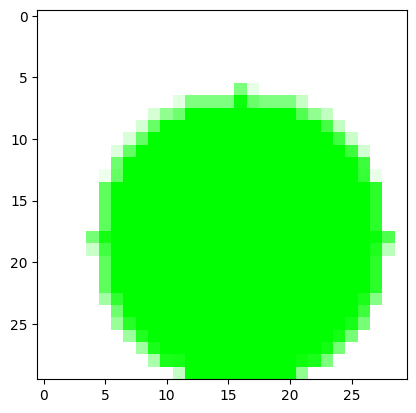

Origin image:


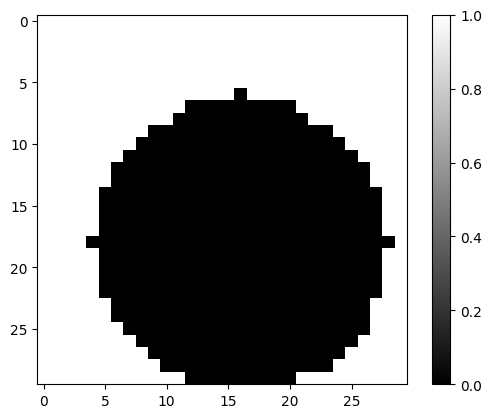

C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


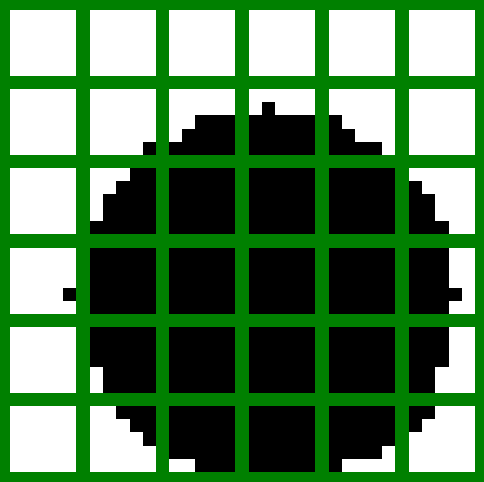

test_idx: 100
predict: circle_green
truth: circle_green


In [171]:
# test_idx = 516
test_idx = 100
image = test_images[test_idx].unsqueeze(0)
print(f"Origin image:")
plt.imshow(image[0].permute(1,2,0))
plt.show()


gray_image = (gray_transform(test_images[test_idx]).unsqueeze(0))
print(f"Origin image:")
plt.imshow(gray_image[0].permute(1,2,0), cmap='gray', vmax=1, vmin=0)
plt.colorbar()
plt.show()
plot_map(split(gray_image)[0].permute(1,2,3,4,0), cmap='gray', vmax=1, vmin=0)

pred = model(image).argmax(dim=1)

print(f"test_idx: {test_idx}")
print(f"predict: {num_to_label[pred[0].item()]}")
print(f"truth: {num_to_label[test_labels[test_idx].item()]}")

# 可視化圖片

In [172]:
FMs = {}
RMs = {}
CIs = {}
RM_CIs = {}
layers = {}

# RGBBlocks

## Layer 0

### FM

FM0:
weights bound: [1.0, 0.0]
weights shape = torch.Size([100, 3, 5, 5])


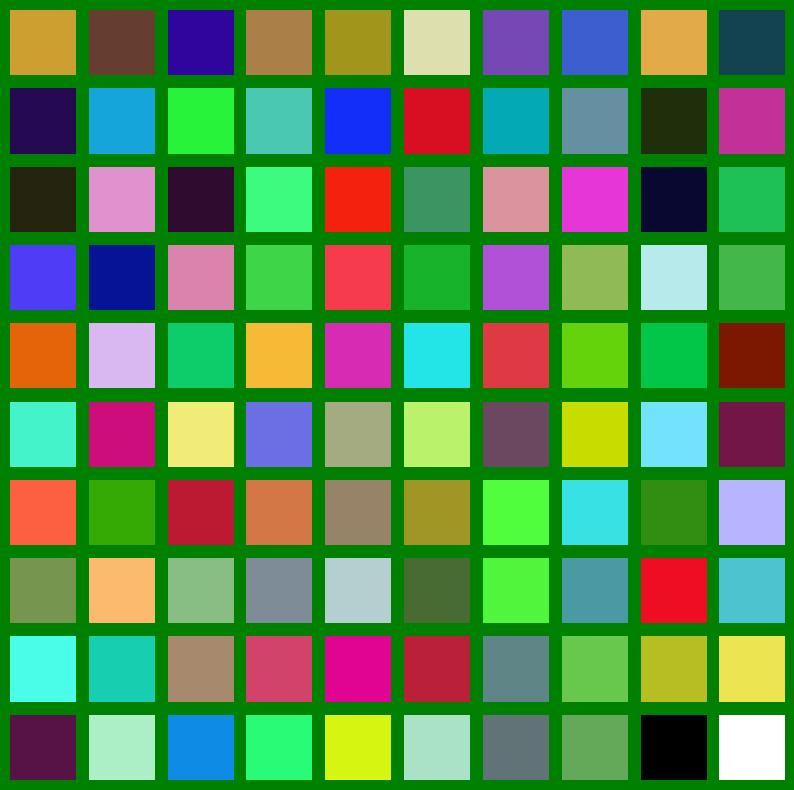

In [173]:
weights = model.RGBBlocks[0][0].weights
weights = torch.concat([weights, model.RGBBlocks[0][0].black_block, model.RGBBlocks[0][0].white_block])

weights = weights.reshape(arch['args']['channels'][0],arch['args']['in_channels'],1,1)
print("FM0:")
print(f"weights bound: [{weights.max().item()}, {weights.min().item()}]")

kernel_size = [5,5]
weights = weights.repeat(1,1,*kernel_size)
print(f"weights shape = {weights.shape}")
FM = weights.detach().numpy()
weights = weights.permute(0,2,3,1).reshape(10,10,*kernel_size,arch['args']['in_channels']).detach().numpy()
plot_map(weights)
FMs['RGBBlocks_0'] = weights

### CI

Sequential(
  (0): RGB_Conv2d(initial = kaiming, weight shape = torch.Size([98, 3]))
  (1): gauss(std=2.75628924369812)
)
segments shape: torch.Size([129600, 5, 5, 3])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([129600, 100])
CI shape: torch.Size([100, 1, 5, 5, 3])


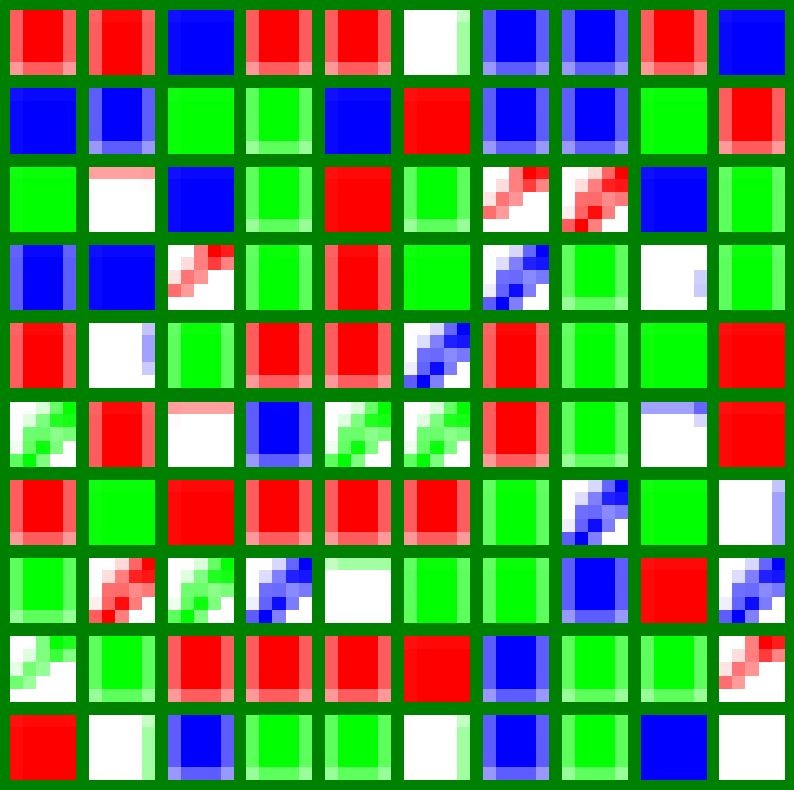

In [174]:
layer = model.RGBBlocks[0][:2]
layers['RGBBlocks_0'] = layer
print(layer)

CI, CI_idx, CI_values = get_ci(train_images, layer)
plot_map(CI.reshape(10,10,*kernel_size,arch['args']['in_channels']))
CIs["RGBBlocks_0"] = CI
# CIs["RGB_Conv2d"] = {"CI":CI, "CI_idx":CI_idx, "CI_values":CI_values}

## Layer 1

### FM

FM: (225, 100, 1, 1)


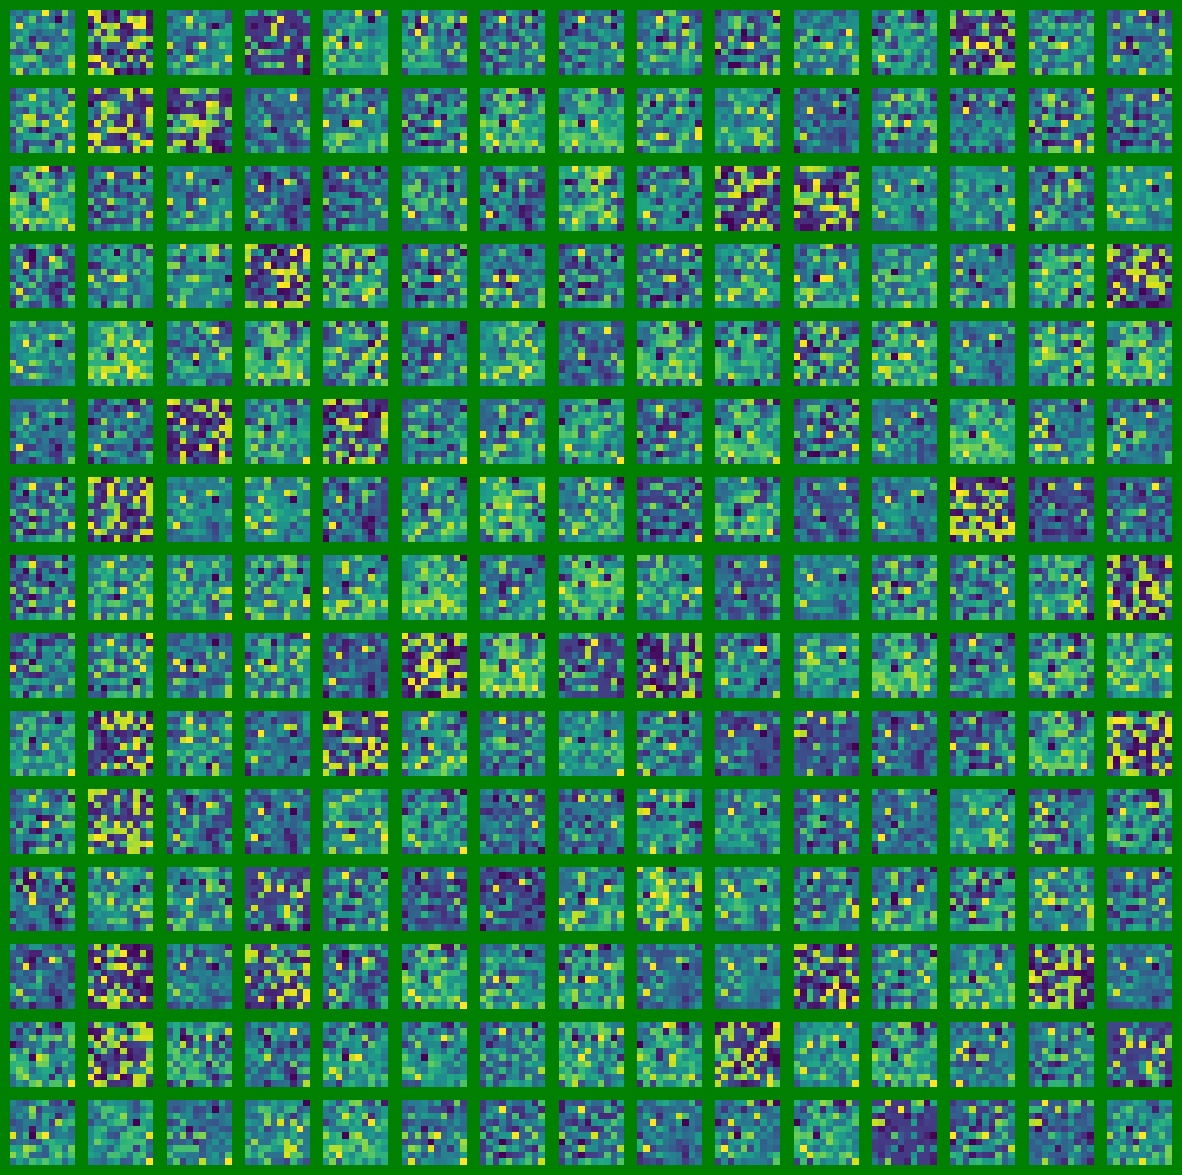

In [175]:
FM = model.RGBBlocks[2][0].weight.unsqueeze(-1).unsqueeze(-1).detach().numpy()
print(f"FM: {FM.shape}")
plot_map(FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1))
FMs["RGBBlocks_1"] = weights

### CI

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): RGB_Conv2d(initial = kaiming, weight shape = torch.Size([98, 3]))
      (1): gauss(std=2.75628924369812)
      (2): cReLU_percent(percent=0.30000001192092896)
    )
    (1): SFM(
      filter=(3, 1), alpha=[[0.9  ]
       [0.945]
       [0.99 ]]
    )
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): gauss(std=1.6845088005065918)
  )
)
(5, 5) (5, 5) tensor([3, 1])
segments shape: torch.Size([43200, 15, 5, 3])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([43200, 225])
CI shape: torch.Size([225, 1, 15, 5, 3])


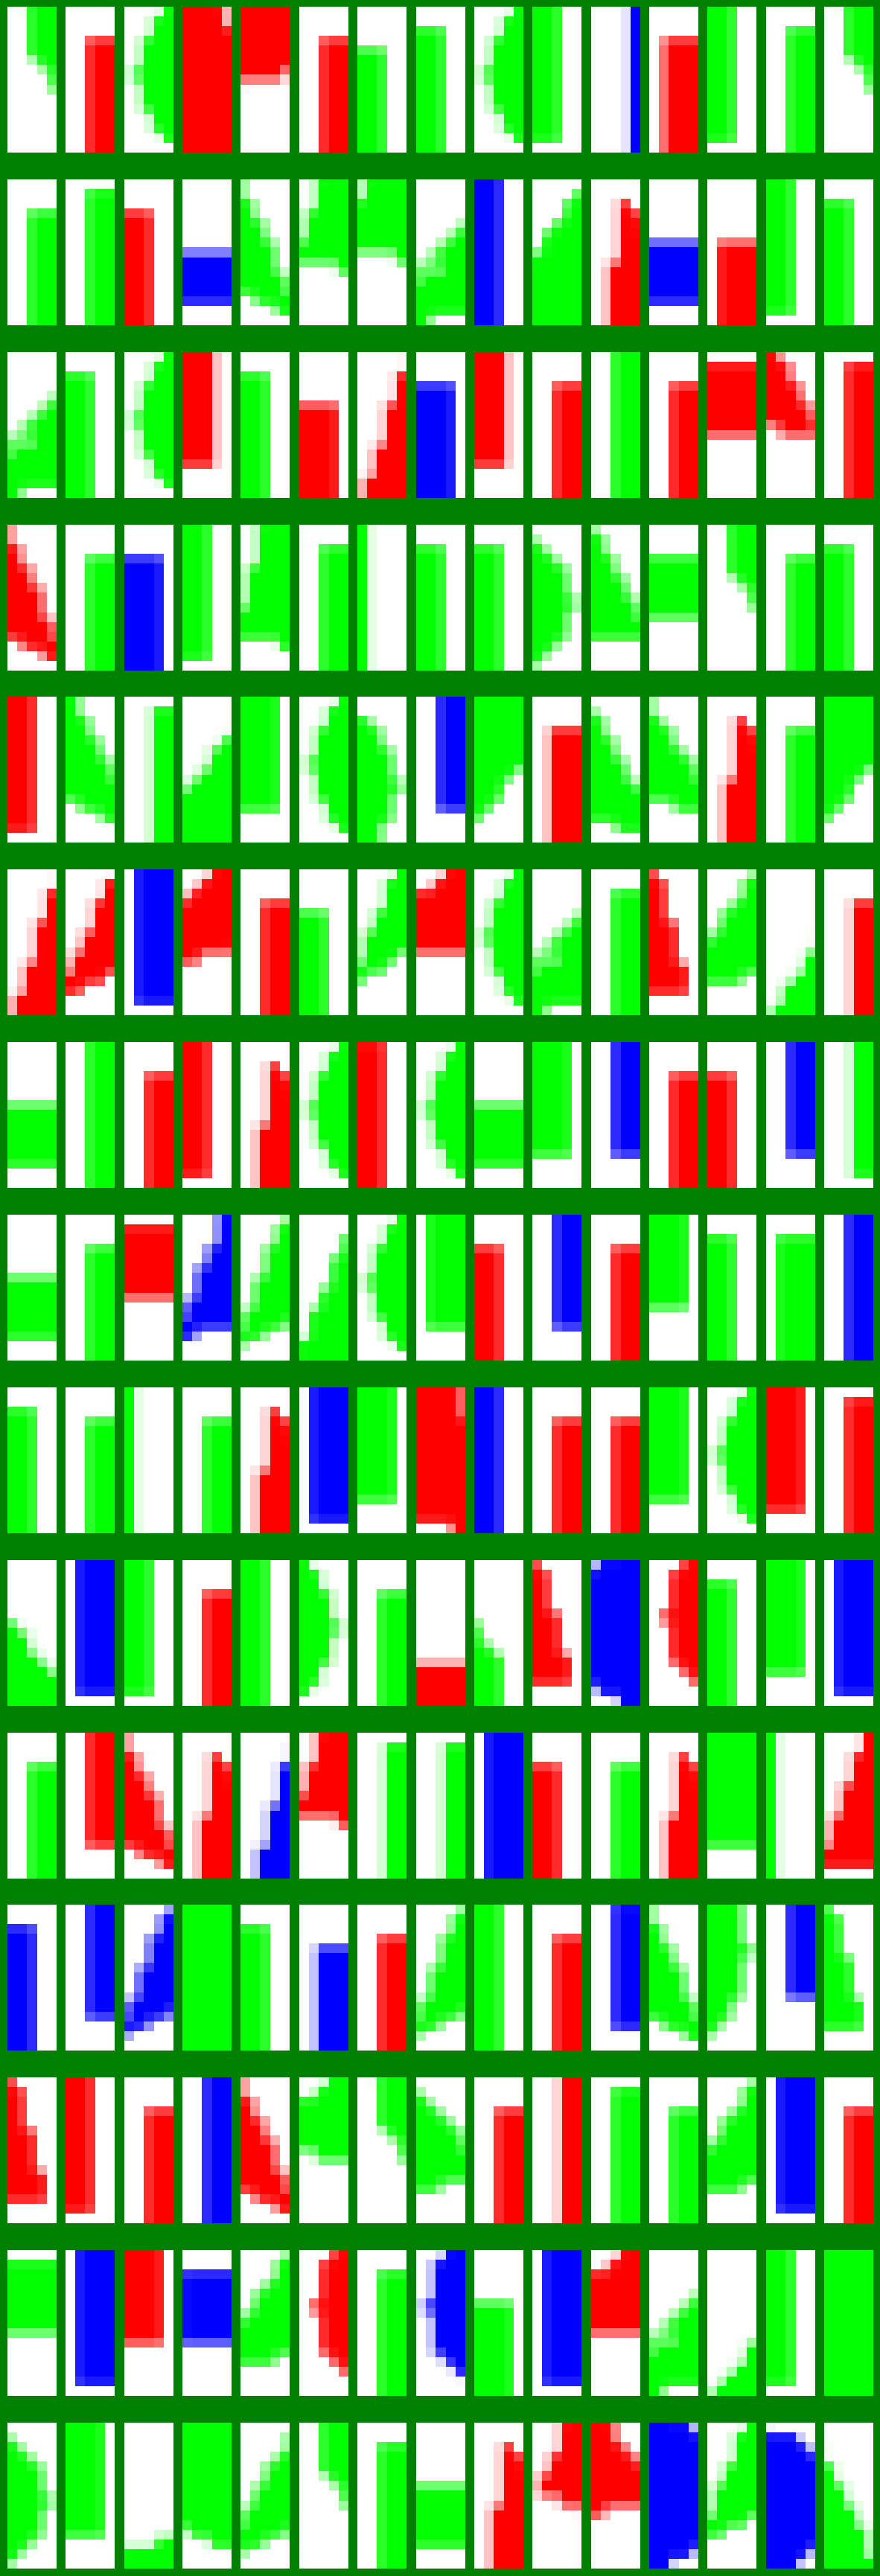

In [176]:
forward = nn.Sequential(
    model.RGBBlocks[:2],
    model.RGBBlocks[2][:2]
)
print(forward)
layers["RGBBlocks_1"] = forward

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:1]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(train_images, forward, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
plot_map(CI.reshape((int(CI.shape[0] ** 0.5), int(CI.shape[0] ** 0.5), *CI.shape[2:])))
CIs["RGBBlocks_1"] = CI

## Layer 2

### FM

FM: (625, 225, 1, 1)


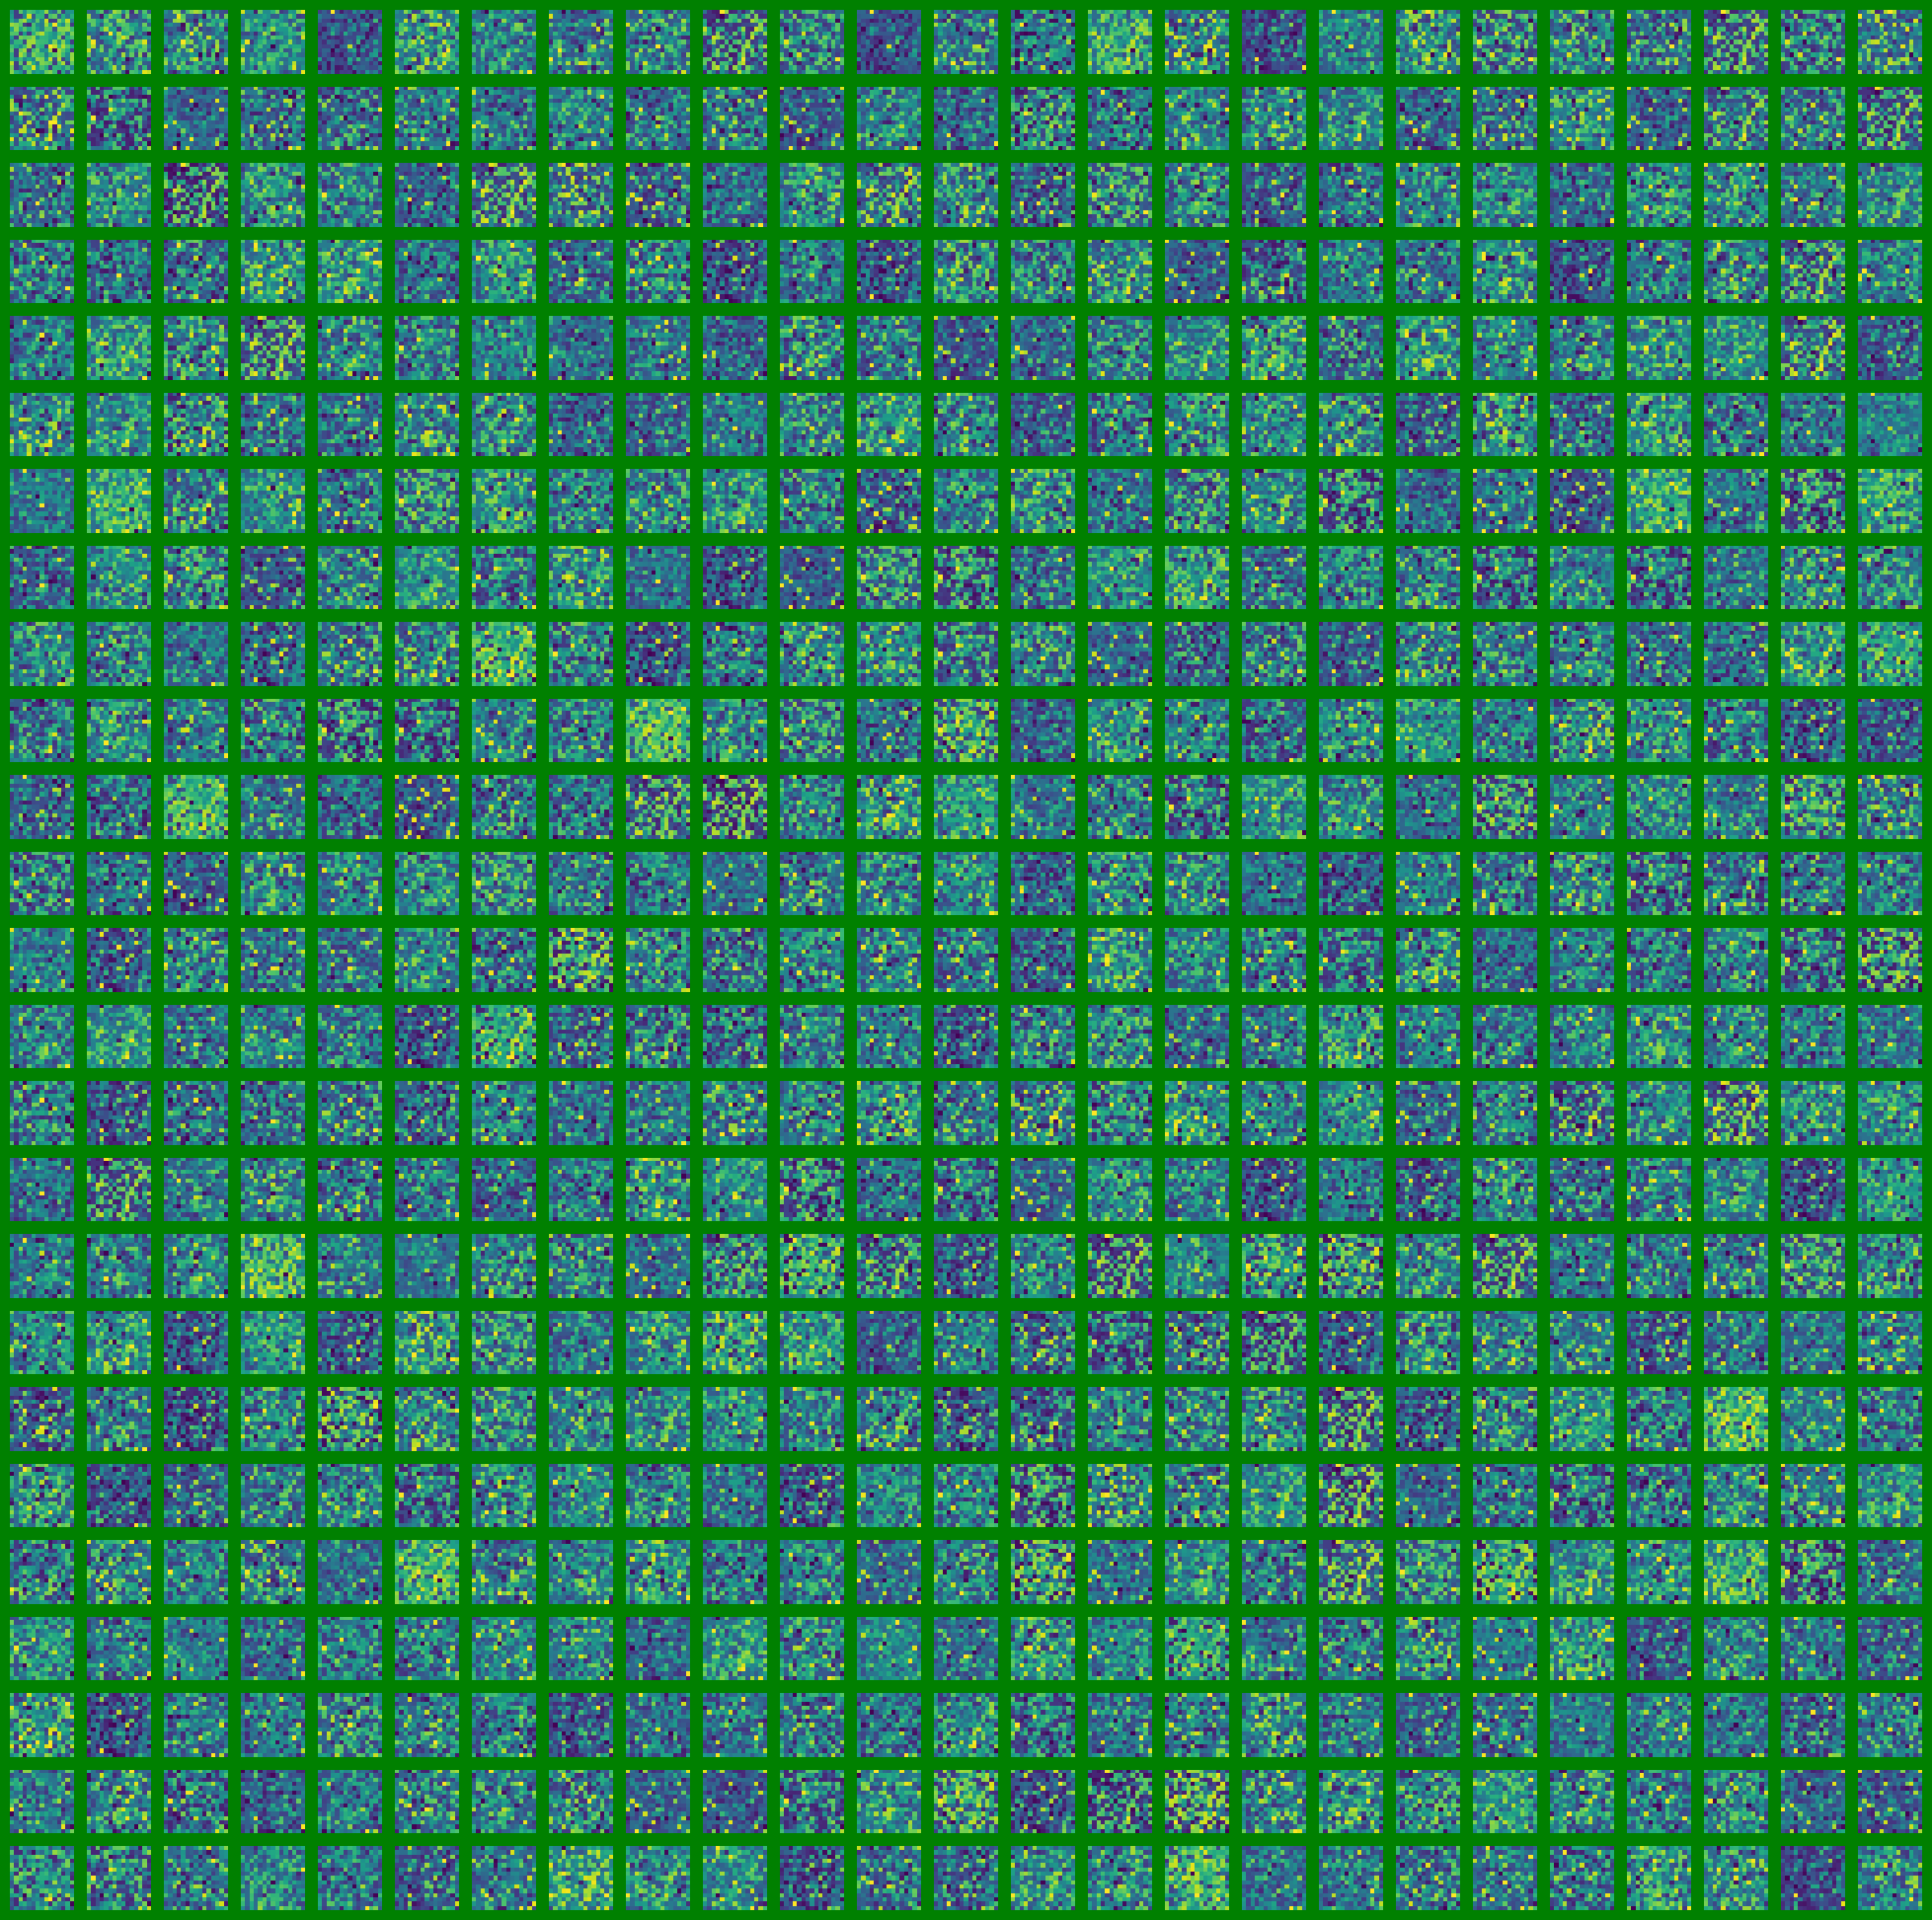

In [177]:
FM = model.RGBBlocks[3][0].weight.unsqueeze(-1).unsqueeze(-1).detach().numpy()
print(f"FM: {FM.shape}")
plot_map(FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1))
FMs["RGBBlocks_2"] = weights

### CI

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): RGB_Conv2d(initial = kaiming, weight shape = torch.Size([98, 3]))
      (1): gauss(std=2.75628924369812)
      (2): cReLU_percent(percent=0.30000001192092896)
    )
    (1): SFM(
      filter=(3, 1), alpha=[[0.9  ]
       [0.945]
       [0.99 ]]
    )
    (2): Sequential(
      (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
      (1): gauss(std=1.6845088005065918)
      (2): cReLU_percent(percent=0.4000000059604645)
      (3): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
    )
  )
  (1): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): gauss(std=1.778041958808899)
  )
)
(5, 5) (5, 5) tensor([3, 3])
segments shape: torch.Size([14400, 15, 15, 3])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([14400, 625])
CI shape: torch.Size([625, 1, 15, 15, 3])


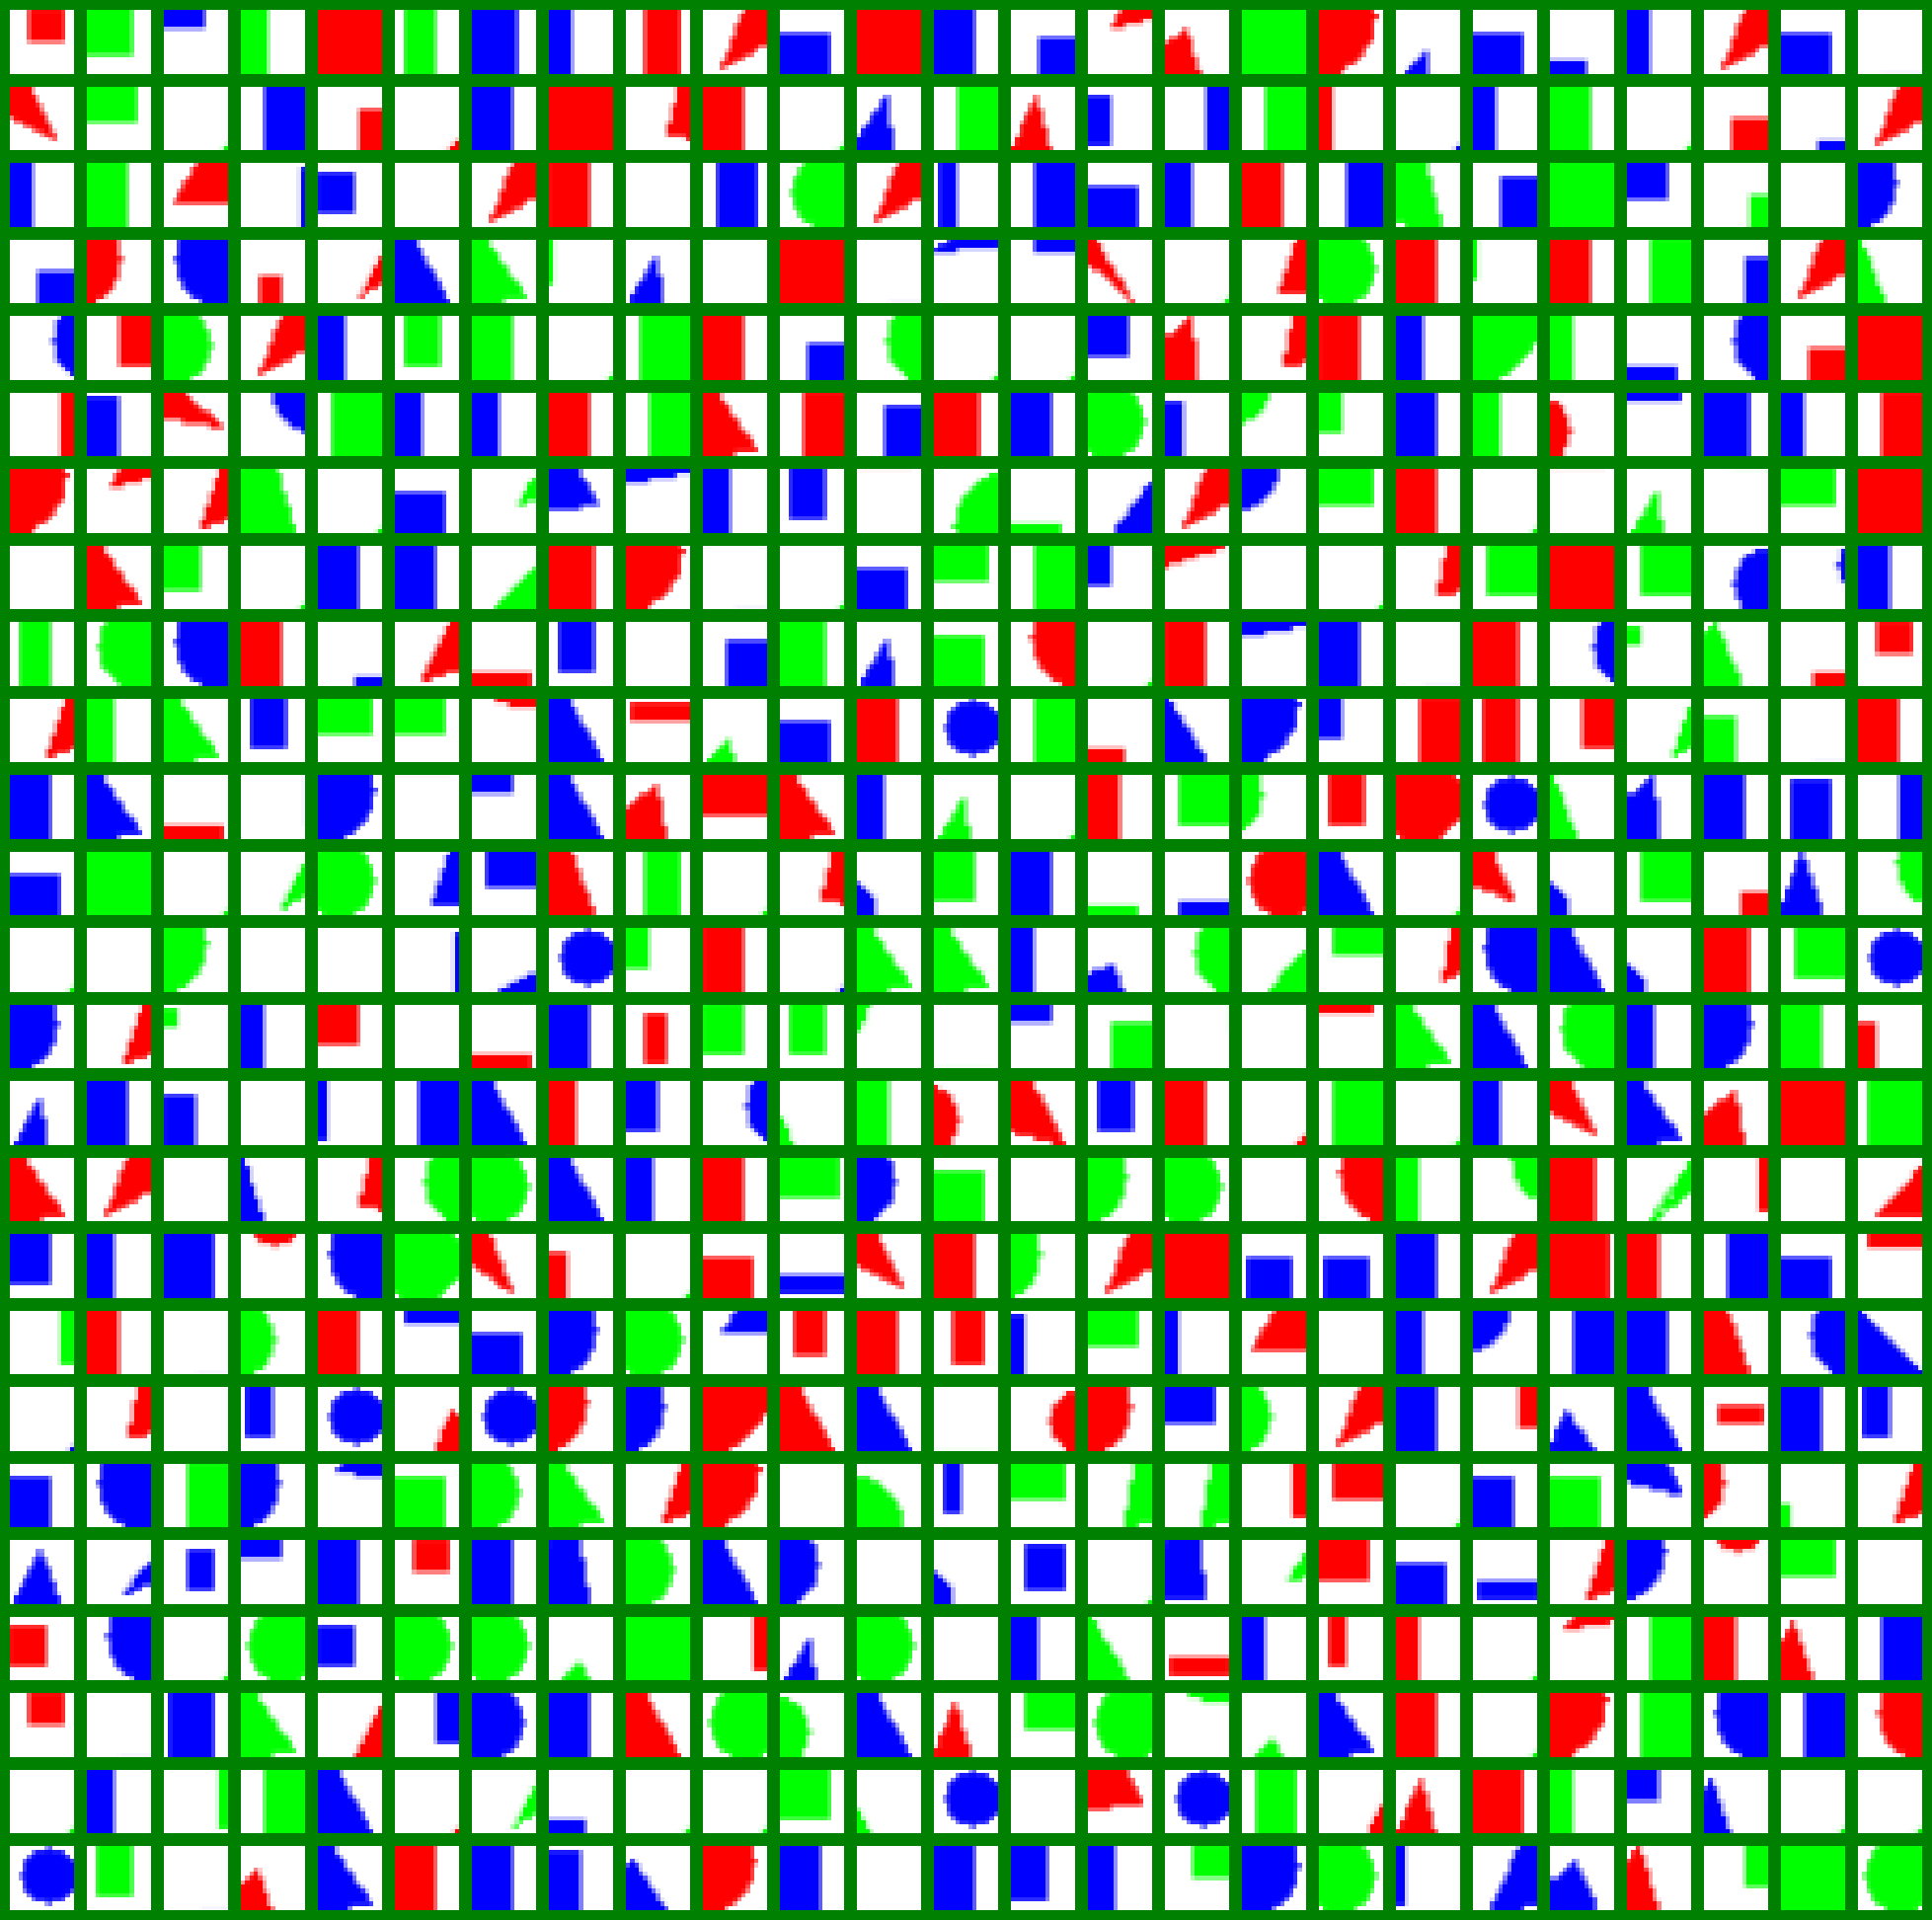

In [178]:
forward = nn.Sequential(
    model.RGBBlocks[:3],
    model.RGBBlocks[3][:2]
)
print(forward)
layers["RGBBlocks_2"] = forward

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:2]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(train_images, forward, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
plot_map(CI.reshape((int(CI.shape[0] ** 0.5), int(CI.shape[0] ** 0.5), *CI.shape[2:])))
CIs["RGBBlocks_2"] = CI

# GrayBlocks

## Layer 0

### FM

FM: (100, 25)


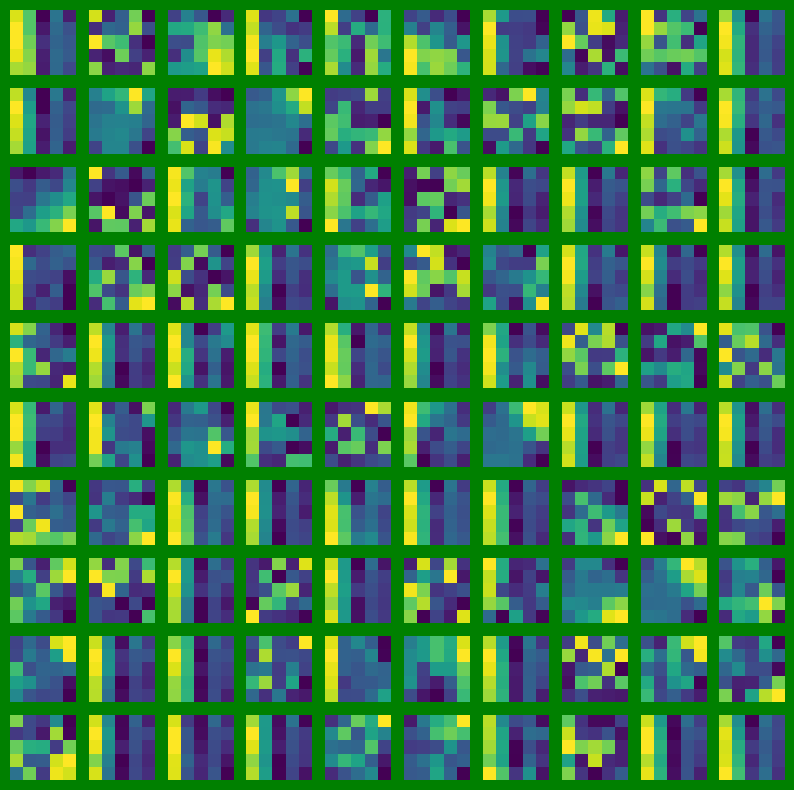

In [179]:
FM = model.GrayBlocks[0][0].weight.detach().numpy()
print(f"FM: {FM.shape}")
plot_map(FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1))
FMs["GrayBlocks_0"] = weights

### CI

Sequential(
  (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
  (1): gauss(std=1.4732141494750977)
)
(5, 5) (5, 5) (1, 1)
segments shape: torch.Size([129600, 5, 5, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([129600, 100])
CI shape: torch.Size([100, 1, 5, 5, 1])
CI_GRAY: 


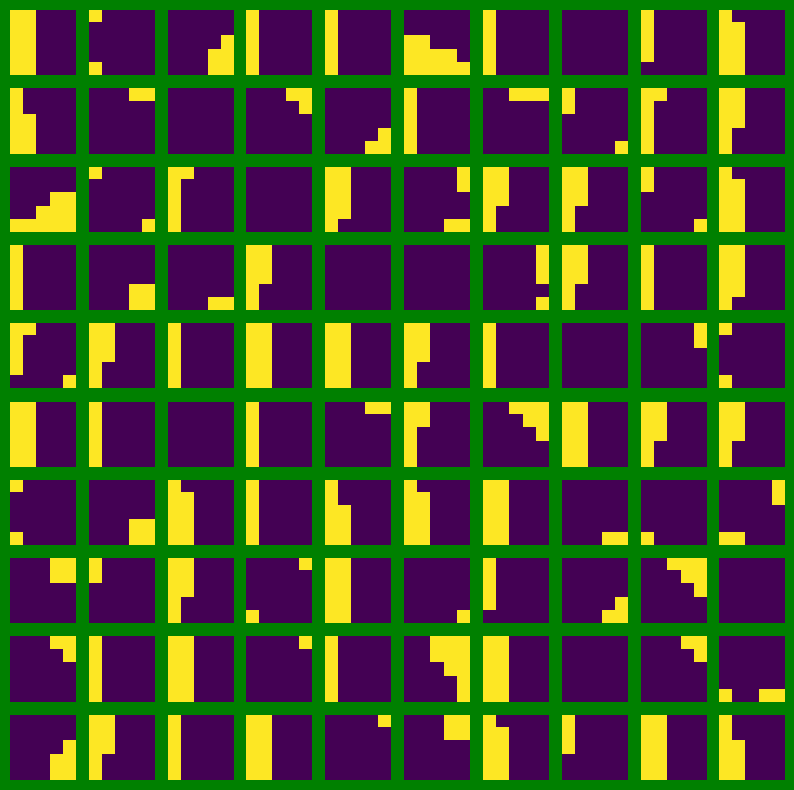

In [191]:
layer = model.GrayBlocks[0][:2]
layers['GrayBlocks_0'] = layer
print(layer)

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = (1,1)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(gray_transform(train_images), layer, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
plot_CI = CI.reshape(int(CI.shape[0]**0.5), int(CI.shape[0]**0.5), *CI.shape[2:])
print("CI_GRAY: ")
plot_map(plot_CI)
CIs["GrayBlocks_0"] = CI
# CIs["Gray_Conv2d"] = {"CI":CI, "CI_idx":CI_idx, "CI_values":CI_values}

## Layer 1

### FM

FM: (225, 100, 1, 1)


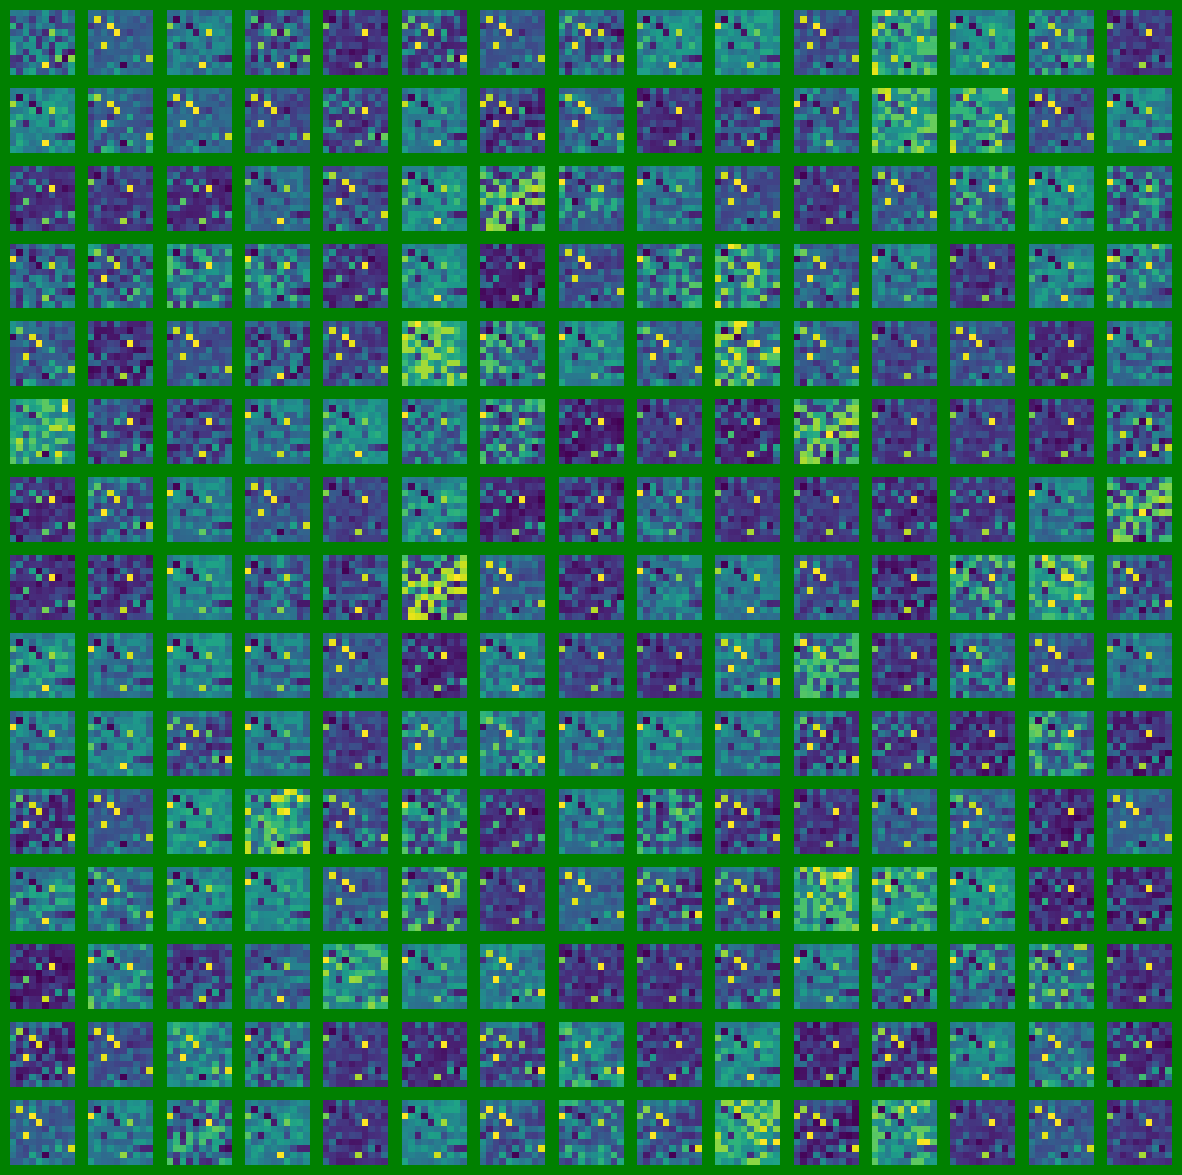

In [181]:
FM = model.GrayBlocks[2][0].weight.unsqueeze(-1).unsqueeze(-1).detach().numpy()
print(f"FM: {FM.shape}")
plot_map(FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1))
FMs['GrayBlocks_1'] = FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1)

### CI

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): gauss(std=1.4732141494750977)
    (2): cReLU_percent(percent=0.30000001192092896)
  )
  (1): SFM(
    filter=(3, 1), alpha=[[0.9  ]
     [0.945]
     [0.99 ]]
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): gauss(std=1.890290379524231)
  )
)
(5, 5) (5, 5) (3, 1)
segments shape: torch.Size([43200, 15, 5, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([43200, 225])
CI shape: torch.Size([225, 1, 15, 5, 1])


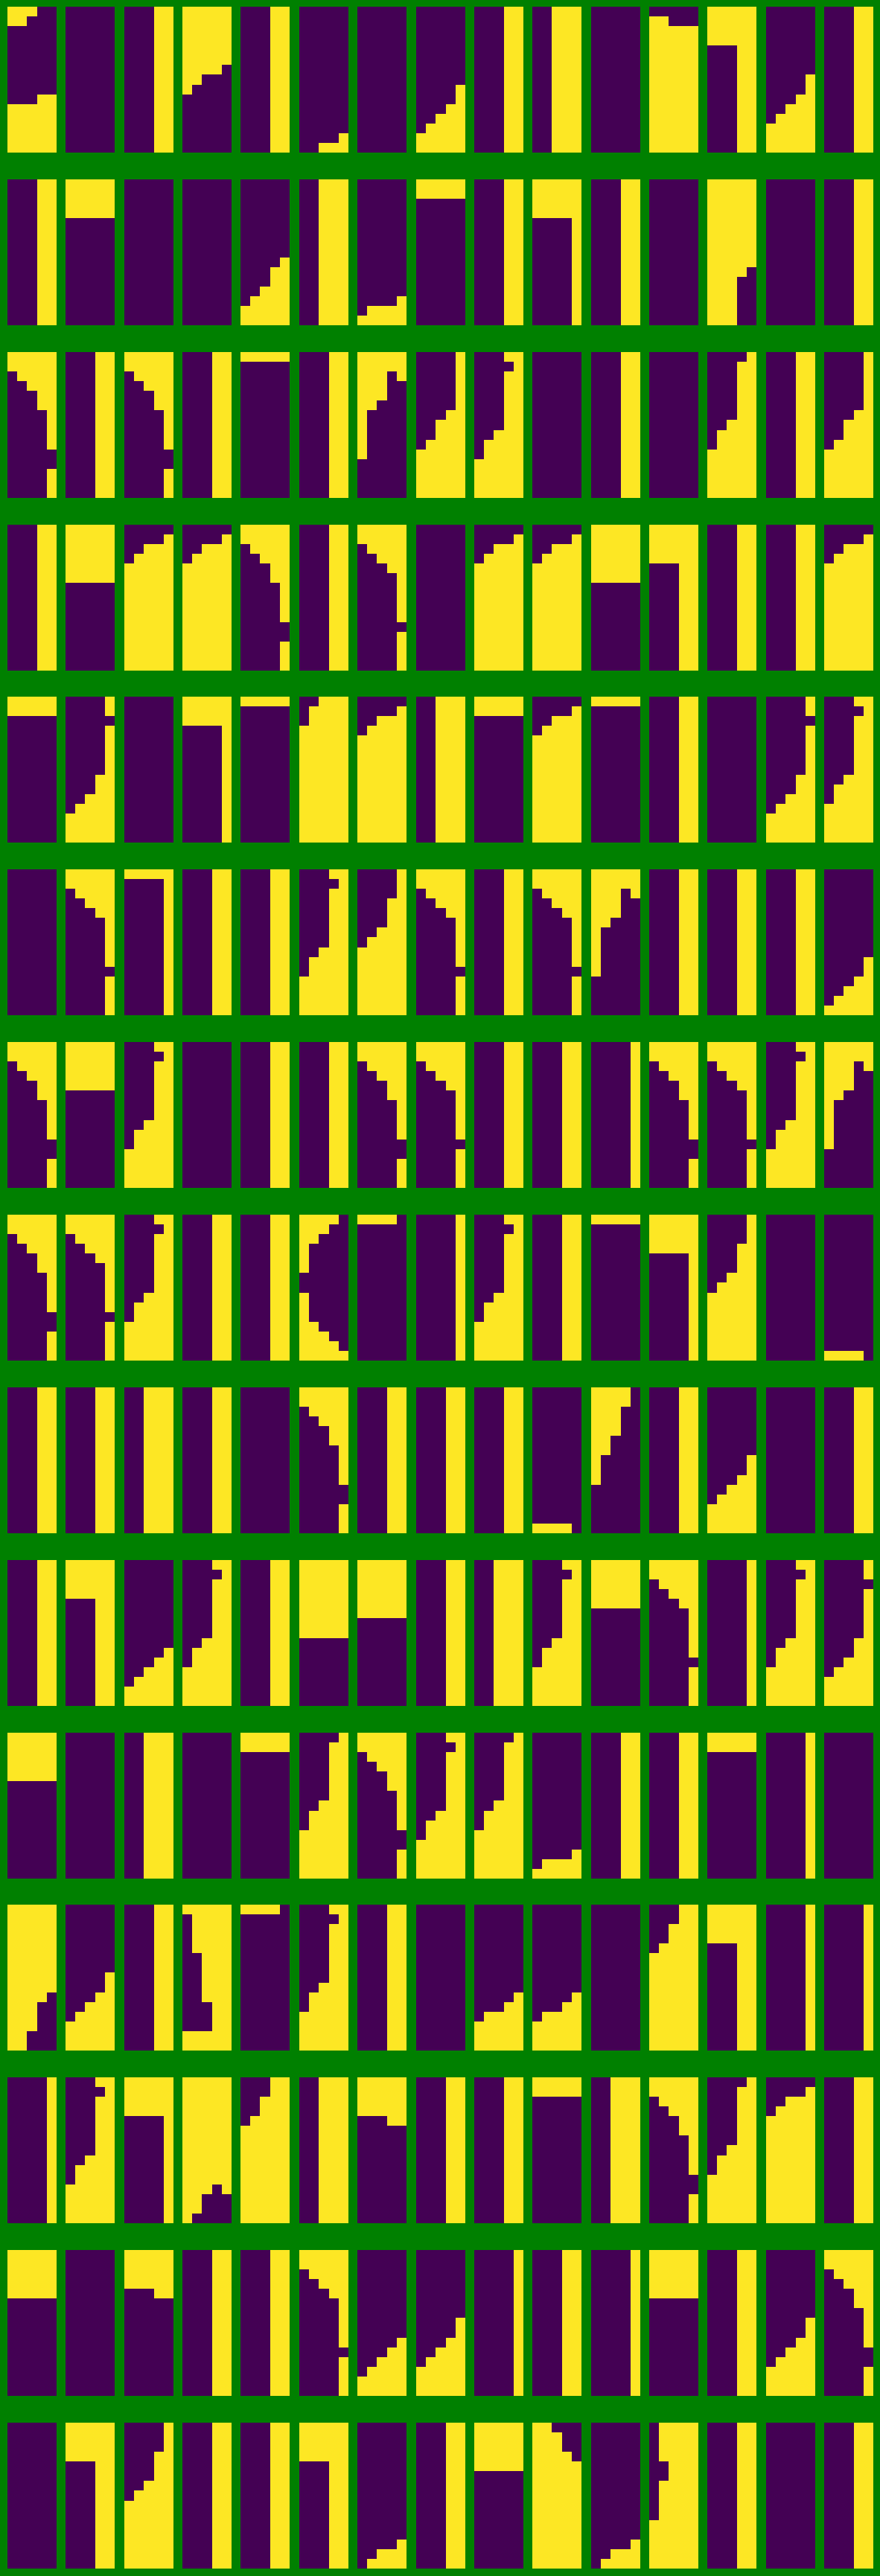

In [182]:
forward = nn.Sequential(*(list(model.GrayBlocks[:2]) + list([model.GrayBlocks[2][:2]])))
print(forward)
layers["GrayBlocks_1"] = forward

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = arch['args']['SFM_filters'][0]
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(gray_transform(train_images), forward, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
plot_map(CI.reshape((int(CI.shape[0] ** 0.5), int(CI.shape[0] ** 0.5), *CI.shape[2:])))
CIs["GrayBlocks_1"] = CI

## Layer 2

### FM

FM: (225, 100, 1, 1)


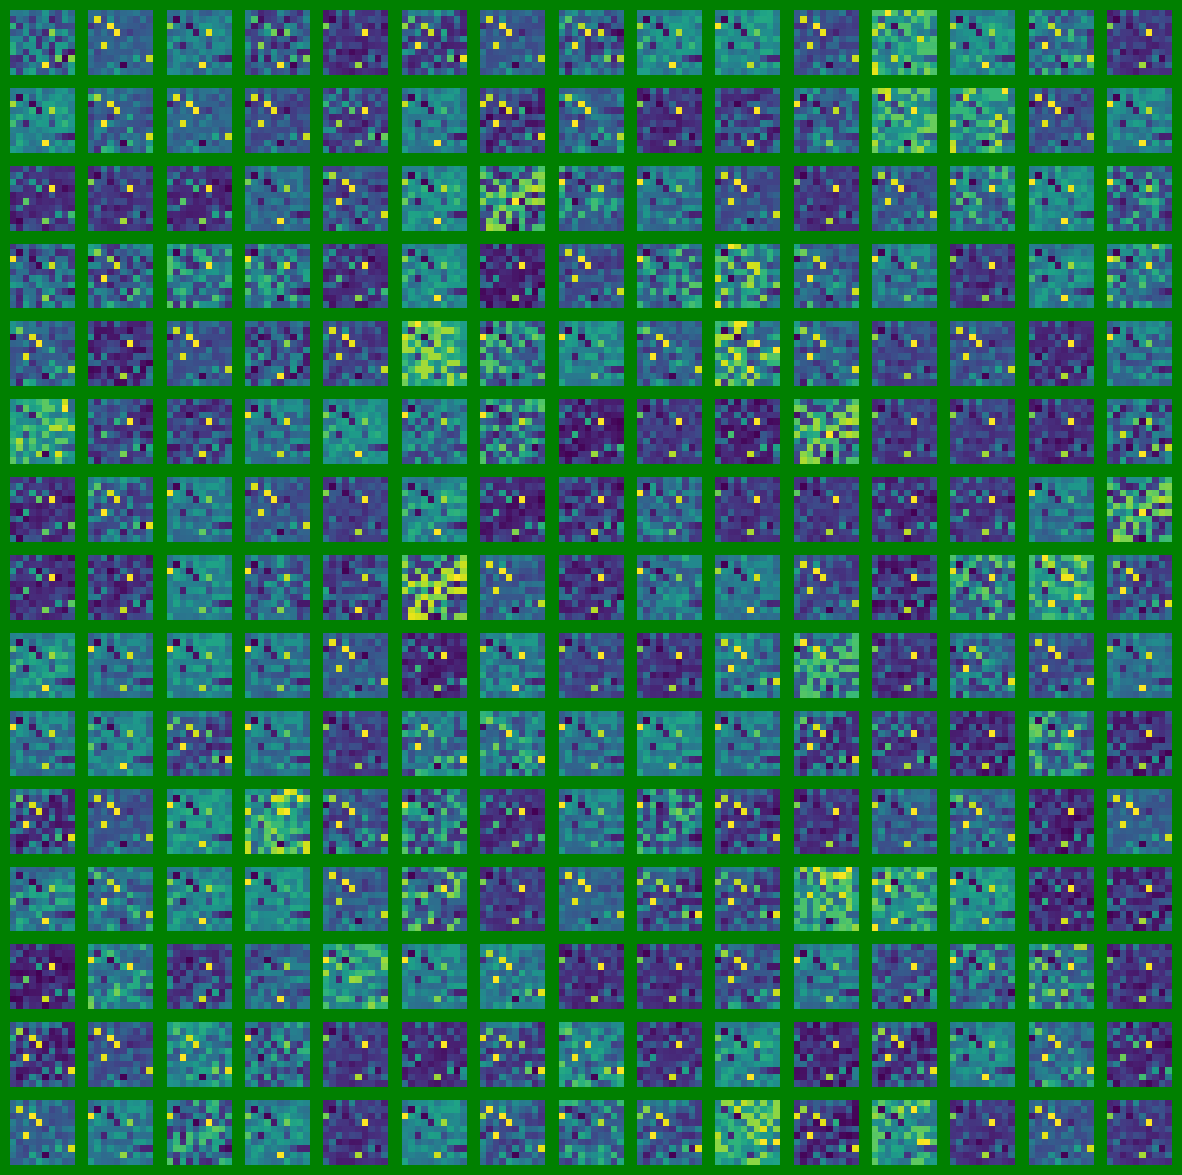

In [183]:
FM = model.GrayBlocks[2][0].weight.unsqueeze(-1).unsqueeze(-1).detach().numpy()
print(f"FM: {FM.shape}")
plot_map(FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1))
FMs['GrayBlocks_2'] = FM.reshape(int(FM.shape[0] ** 0.5), int(FM.shape[0] ** 0.5), int(FM.shape[1] ** 0.5), int(FM.shape[1] ** 0.5), 1)

### CI

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): gauss(std=1.4732141494750977)
    (2): cReLU_percent(percent=0.30000001192092896)
  )
  (1): SFM(
    filter=(3, 1), alpha=[[0.9  ]
     [0.945]
     [0.99 ]]
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): gauss(std=1.890290379524231)
    (2): cReLU_percent(percent=0.4000000059604645)
    (3): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
  )
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): gauss(std=1.5281661748886108)
  )
)
(5, 5) (5, 5) tensor([3, 3])
segments shape: torch.Size([14400, 15, 15, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


output shape: torch.Size([14400, 625])
CI shape: torch.Size([625, 1, 15, 15, 1])


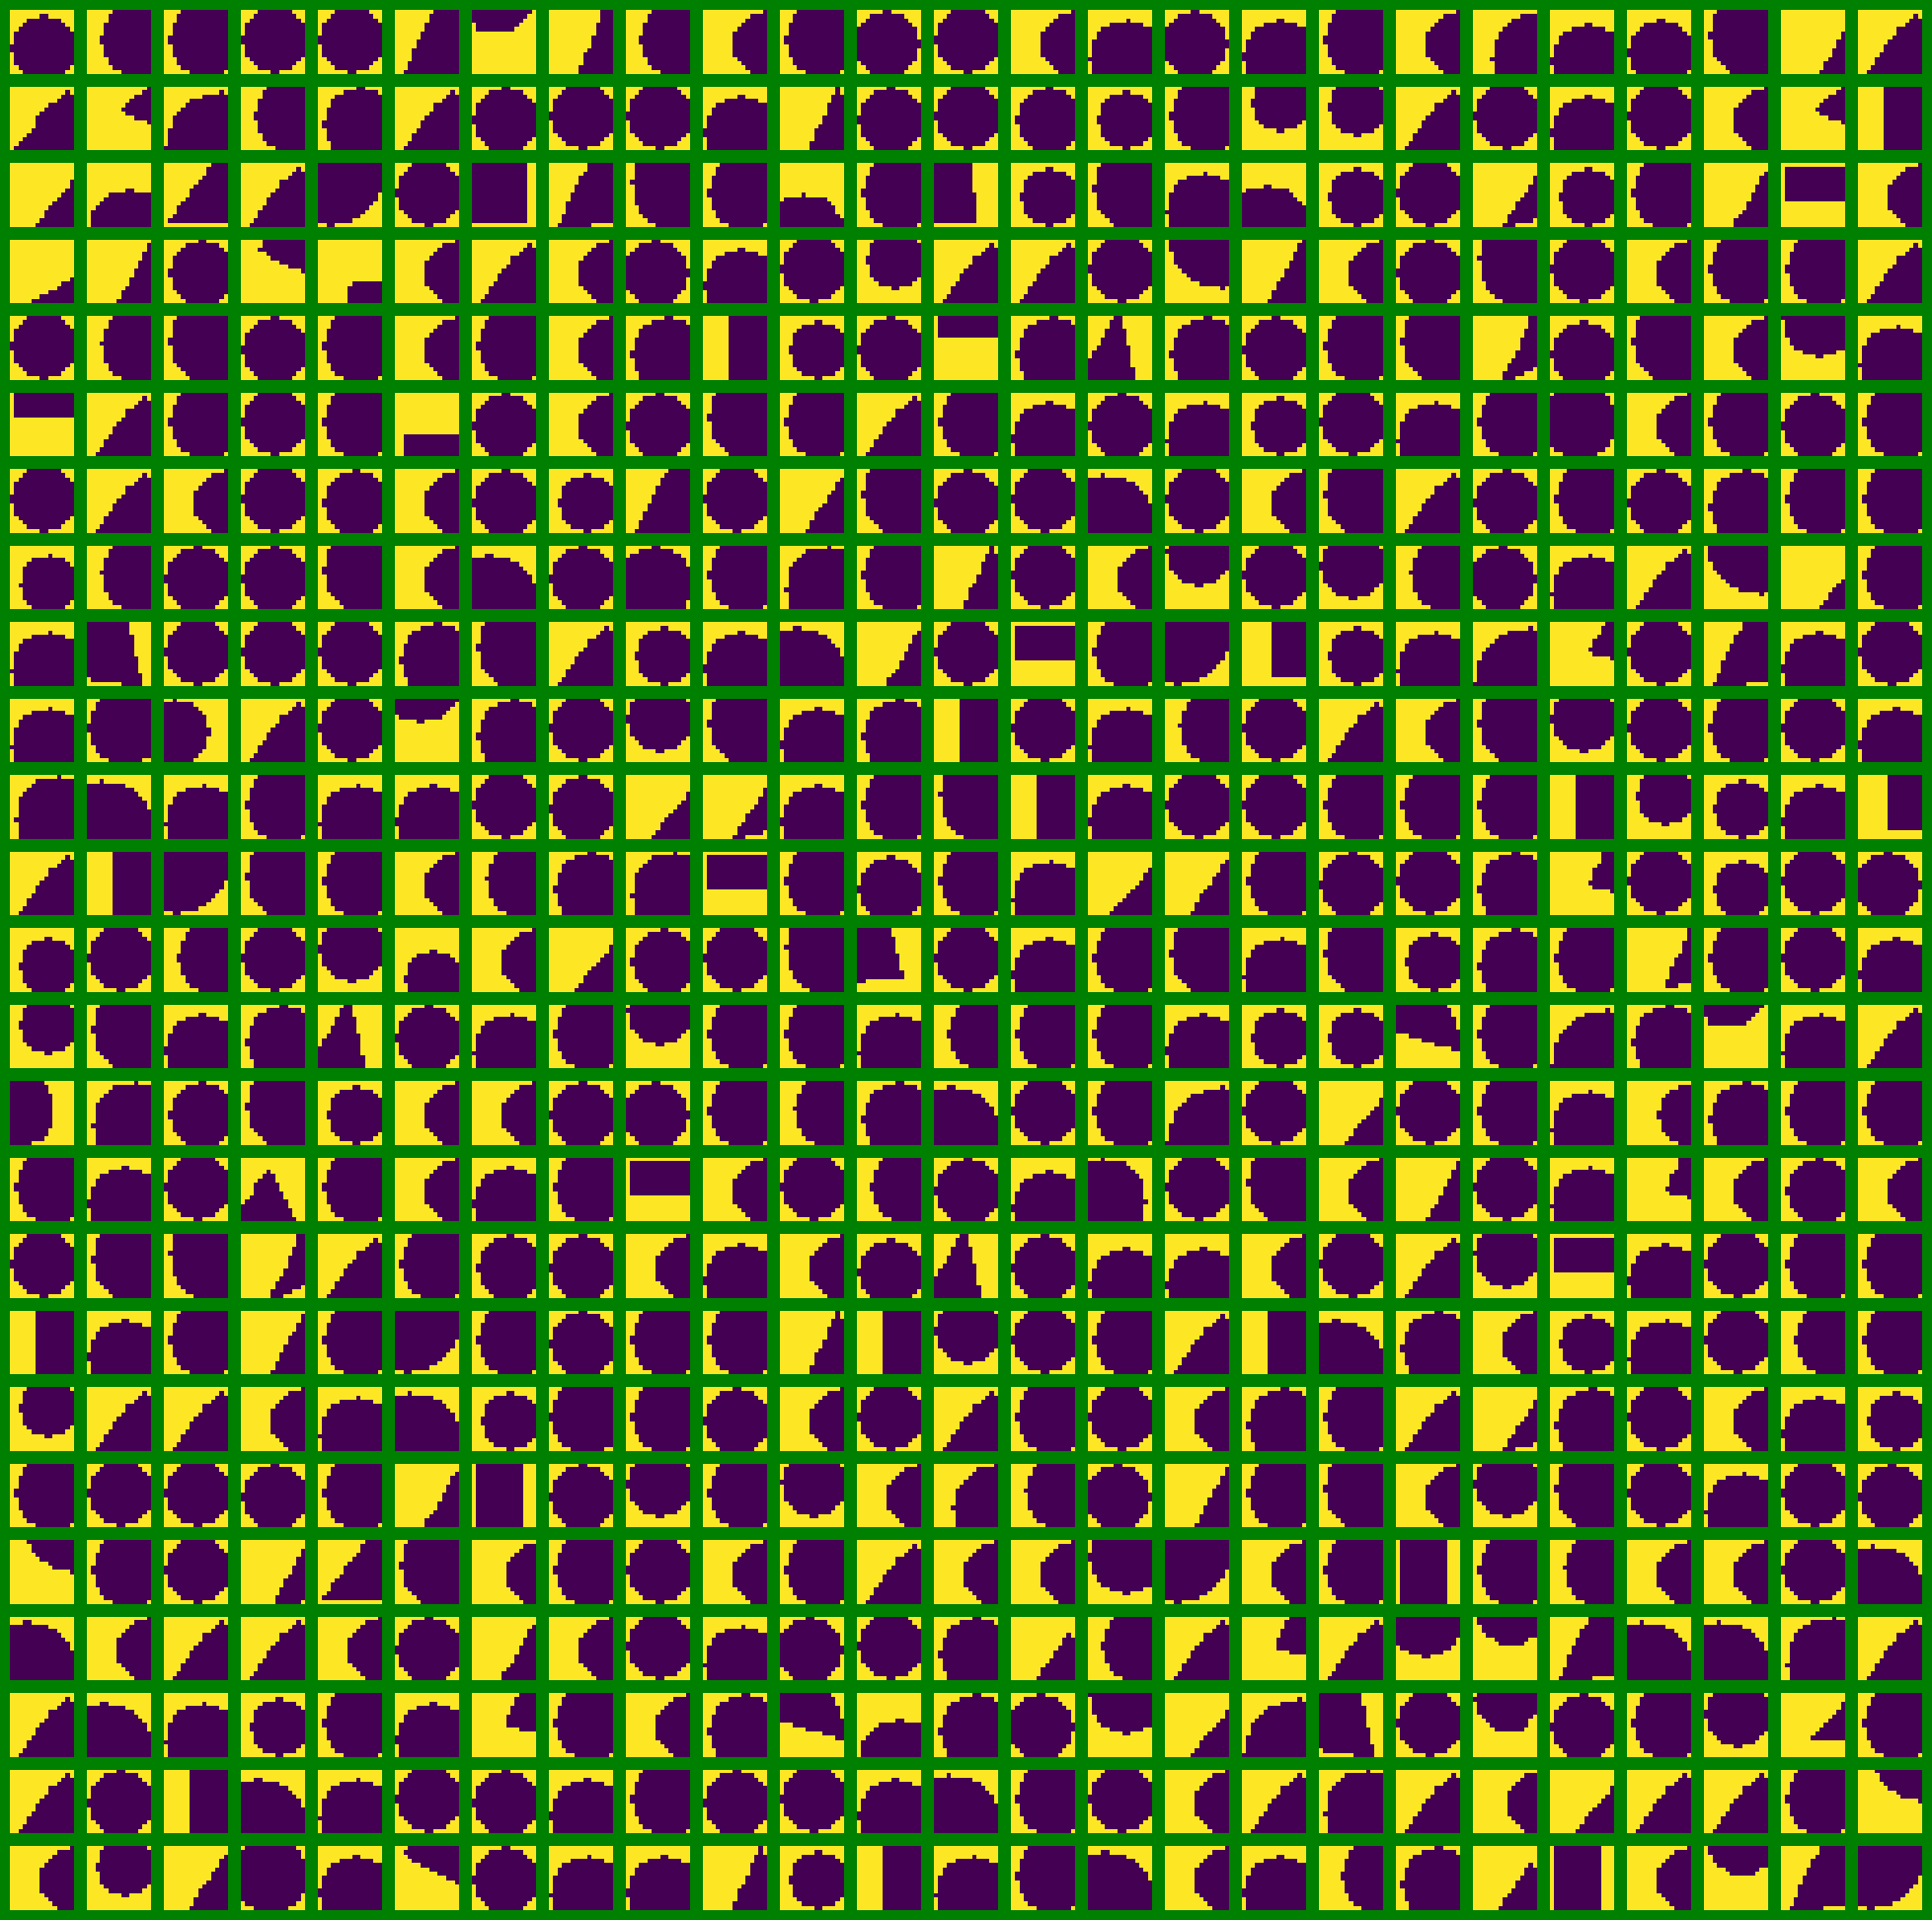

In [184]:
forward = nn.Sequential(*(list(model.GrayBlocks[:3]) + list([model.GrayBlocks[3][:2]])))
print(forward)
layers["GrayBlocks_2"] = forward

kernel_size=arch['args']['Conv2d_kernel'][0]
stride = (arch['args']['strides'][0], arch['args']['strides'][0]) 
sfm_filter = torch.prod(torch.tensor(arch['args']['SFM_filters'][:2]), dim=0)
print(kernel_size, stride, sfm_filter)

CI, CI_idx, CI_values = get_ci(gray_transform(train_images), forward, kernel_size=kernel_size, stride=stride, sfm_filter=sfm_filter)
plot_map(CI.reshape((int(CI.shape[0] ** 0.5), int(CI.shape[0] ** 0.5), *CI.shape[2:])))
CIs["GrayBlocks_2"] = CI

# RM、RM-CI


102


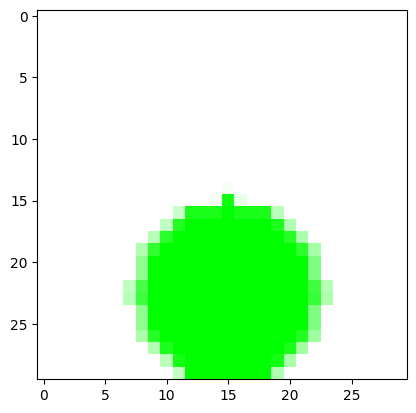

torch.Size([3, 6, 6, 5, 5])


C:\Users\user\AppData\Local\Temp\ipykernel_36232\250682733.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


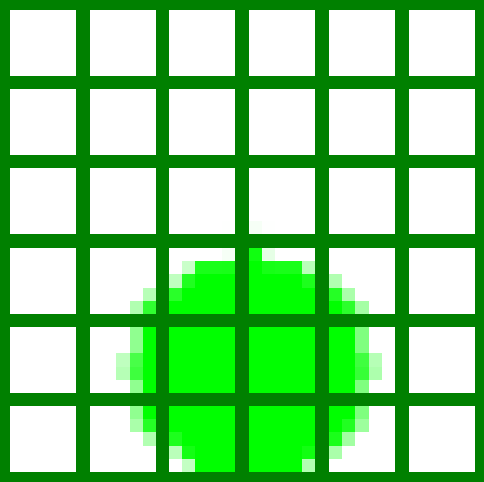

In [203]:
import random
test_idx = random.randint(0, len(test_images))
print(test_idx)

test_img = test_images[test_idx]
plt.imshow(test_img.permute(1,2,0))
plt.show()

segments = split(test_img.unsqueeze(0), stride=(5,5))[0]
print(segments.shape)
plot_map(segments.permute(1,2,3,4,0))

## RGBBlocks_0

RM0: torch.Size([100, 6, 6])


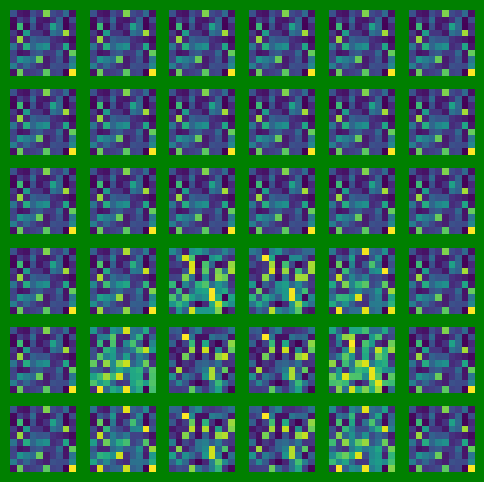

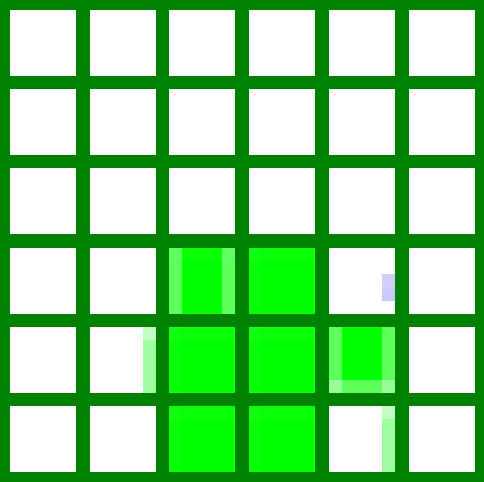

In [204]:
layer_num = 'RGBBlocks_0'
RM = layers[layer_num](test_img.unsqueeze(0))[0]
RM_H, RM_W = RM.shape[1], RM.shape[2]
print(f"RM0: {RM.shape}")
plot_map(RM.detach().numpy().transpose(1,2,0).reshape(RM_H, RM_W,10,10,1))

CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,3)
plot_map(RM_CI)

## RGBBlocks_1

RM0: torch.Size([225, 2, 6])


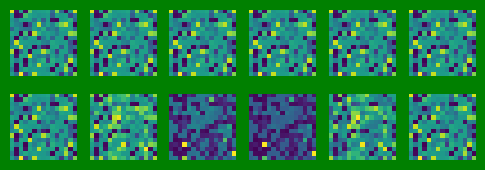

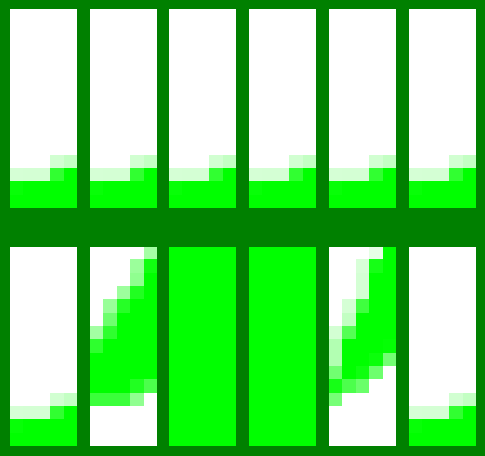

In [205]:
layer_num = 'RGBBlocks_1'
RM = layers[layer_num](test_img.unsqueeze(0))[0]
RM_H, RM_W = RM.shape[1], RM.shape[2]
print(f"RM0: {RM.shape}")
plot_map(RM.detach().numpy().transpose(1,2,0).reshape(RM_H, RM_W,15,15,1))

CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,3)
plot_map(RM_CI)

## RGBBlocks_2

RM0: torch.Size([625, 2, 2])


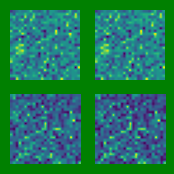

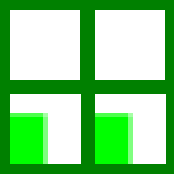

In [206]:
layer_num = 'RGBBlocks_2'
RM = layers[layer_num](test_img.unsqueeze(0))[0]
RM_H, RM_W = RM.shape[1], RM.shape[2]
print(f"RM0: {RM.shape}")
plot_map(RM.detach().numpy().transpose(1,2,0).reshape(RM_H, RM_W,int(RM.shape[0]**0.5),int(RM.shape[0]**0.5),1))

CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,3)
plot_map(RM_CI)

## GrayBlocks_0

Sequential(
  (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
  (1): gauss(std=1.4732141494750977)
)
torch.Size([100, 6, 6])


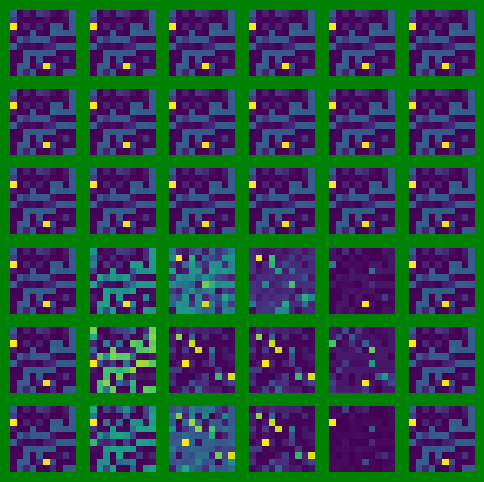

torch.Size([100, 1, 5, 5, 1])


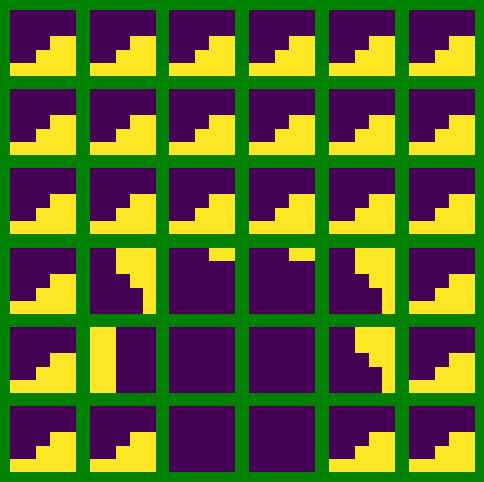

In [209]:
layer_num = 'GrayBlocks_0'
print(layers[layer_num])
RM = layers[layer_num](gray_transform(test_img).unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1).detach().numpy())

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

## GrayBlocks_1

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): gauss(std=1.4732141494750977)
    (2): cReLU_percent(percent=0.30000001192092896)
  )
  (1): SFM(
    filter=(3, 1), alpha=[[0.9  ]
     [0.945]
     [0.99 ]]
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): gauss(std=1.890290379524231)
  )
)
torch.Size([225, 2, 6])


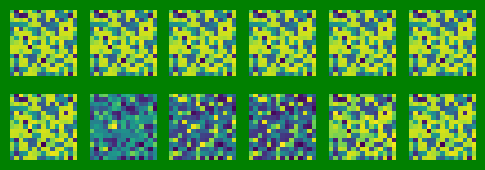

torch.Size([225, 1, 15, 5, 1])


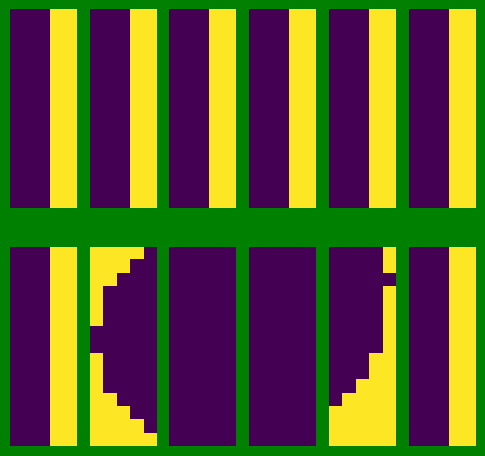

In [220]:
layer_num = "GrayBlocks_1"
print(layers[layer_num])
RM = layers[layer_num](gray_transform(test_img).unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1).detach().numpy())

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

## GrayBlocks_2

Sequential(
  (0): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (100, 1, 5, 5))
    (1): gauss(std=1.4732141494750977)
    (2): cReLU_percent(percent=0.30000001192092896)
  )
  (1): SFM(
    filter=(3, 1), alpha=[[0.9  ]
     [0.945]
     [0.99 ]]
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 100, 1, 1))
    (1): gauss(std=1.890290379524231)
    (2): cReLU_percent(percent=0.4000000059604645)
    (3): SFM(filter=(1, 3), alpha=[[0.9   0.945 0.99 ]])
  )
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): gauss(std=1.5281661748886108)
  )
)
torch.Size([625, 2, 2])


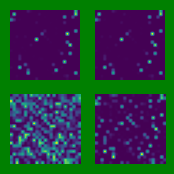

torch.Size([625, 1, 15, 15, 1])


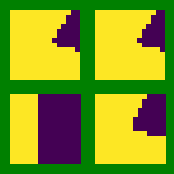

In [224]:
layer_num = "GrayBlocks_2"
print(layers[layer_num])
RM = layers[layer_num](gray_transform(test_img).unsqueeze(0))[0]
print(RM.shape)
RM_H, RM_W = RM.shape[1], RM.shape[2]
plot_map(RM.permute(1,2,0).reshape(RM_H,RM_W,int(RM.shape[0] ** 0.5),int(RM.shape[0] ** 0.5),1).detach().numpy())

print(CIs[layer_num].shape)
CI_H, CI_W = CIs[layer_num].shape[2], CIs[layer_num].shape[3]
RM_CI = CIs[layer_num][torch.topk(RM, k=1, dim=0, largest=True).indices.flatten()].reshape(RM_H,RM_W,CI_H,CI_W,1)
plot_map(RM_CI)

# Inference

In [ ]:
def cdist(x, y):
    return np.sum((x-y) ** 2) ** 0.5

In [ ]:
def get_RM_CIs(image):
    RM_CIs = {}

    layer = model.RGB_conv2d[0]
    RM_RGB = layer(image)[0]
    CI, CI_idx = CIs['RGB_Conv2d']["CI"], CIs['RGB_Conv2d']["CI_idx"]
    RM_CI = CI[torch.topk(RM_RGB, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape(6,6,5,5,3)
    RM_CI_idx = CI_idx[torch.topk(RM_RGB, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape(6,6)
    RM_CIs['RGB_Conv2d'] = {"RM_CI":RM_CI.detach().numpy(), "RM_CI_idx":RM_CI_idx.detach().numpy()}

    # Gray_conv2d
    layer = model.GRAY_conv2d[0]
    RM_gray = layer(gray_transform(image))[0]
    CI, CI_idx = CIs['Gray_Conv2d']["CI"], CIs['Gray_Conv2d']["CI_idx"]
    RM_CI = CI[torch.topk(RM_gray, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape(6,6,5,5,1)
    RM_CI_idx = CI_idx[torch.topk(RM_gray, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape(6,6)
    RM_CIs['Gray_Conv2d'] = {"RM_CI":RM_CI.detach().numpy(), "RM_CI_idx":RM_CI_idx.detach().numpy()}

    # Conv1
    def forward(image):
        with torch.no_grad():
            rgb_output = model.RGB_conv2d(image)
            gray_output = model.GRAY_conv2d(gray_transform(image))
            output = torch.concat(([rgb_output, gray_output]), dim=1)
            output = model.SFM(output)
            output = model.convs[0][0](output)
        return output
    RM = forward(image)[0]
    CI, CI_idx = CIs['Conv1']["CI"], CIs['Conv1']["CI_idx"]
    RM_CI = CI[torch.topk(RM, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape((2,6,15,5,3))
    RM_CI_idx = CI_idx[torch.topk(RM, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape((2,6))
    RM_CIs['Conv1'] = {"RM_CI":RM_CI.detach().numpy(), "RM_CI_idx":RM_CI_idx.detach().numpy()}

    # Conv2
    def forward(image):
        with torch.no_grad():
            rgb_output = model.RGB_conv2d(image)
            
            gray_output = model.GRAY_conv2d(gray_transform(image))
            output = torch.concat(([rgb_output, gray_output]), dim=1)
            output = model.SFM(output)
            output = nn.Sequential(
                *model.convs[0],
                model.convs[1][0]
            )(output)
        return output
    RM = forward(image)[0]
    CI, CI_idx = CIs['Conv2']["CI"], CIs['Conv2']["CI_idx"]
    RM_CI = CI[torch.topk(RM, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape((2,2,15,15,3))
    RM_CI_idx = CI_idx[torch.topk(RM, k=1, dim=0, largest=False).indices.flatten().detach().tolist()].reshape(2,2)
    RM_CIs['Conv2'] = {"RM_CI":RM_CI.detach().numpy(), "RM_CI_idx":RM_CI_idx.detach().numpy()}
    
    return RM_CIs

image = test_images[test_idx].unsqueeze(0)
RM_CIs = get_RM_CIs(image)

TypeError: new(): invalid data type 'str'

## Test version

(6, 6, 5, 5, 3)


C:\Users\user\AppData\Local\Temp\ipykernel_9016\3983888431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


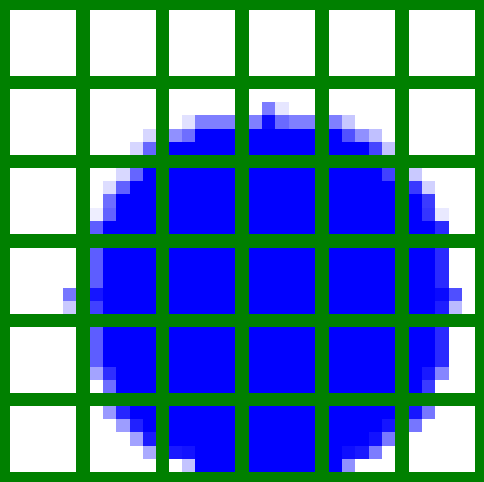

(6, 6, 5, 5, 3)
(6, 6)


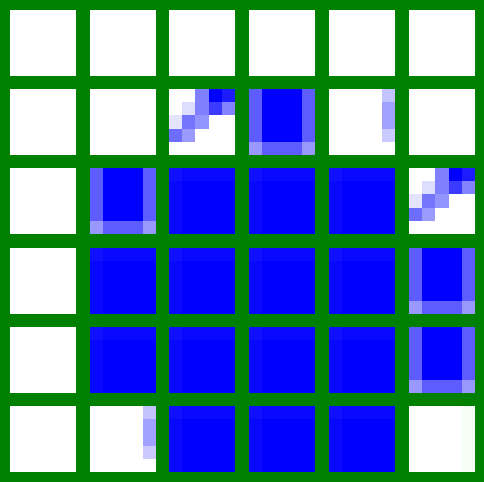

dist_arr: (6, 6)
(0, 0)
[1. 1. 1.]
[1. 1. 1.]

(0, 1)
[1. 1. 1.]
[1. 1. 1.]

(0, 2)
[1. 1. 1.]
[1. 1. 1.]

(0, 3)
[1. 1. 1.]
[1. 1. 1.]

(0, 4)
[1. 1. 1.]
[1. 1. 1.]

(0, 5)
[1. 1. 1.]
[1. 1. 1.]

(1, 0)
[1. 1. 1.]
[1. 1. 1.]

(1, 1)
[1. 1. 1.]
[1. 1. 1.]

(1, 2)
[1. 1. 1.]
[1. 1. 1.]

(1, 3)
[1. 1. 1.]
[0.3666668 0.3666668 1.       ]

(1, 4)
[1. 1. 1.]
[1. 1. 1.]

(1, 5)
[1. 1. 1.]
[1. 1. 1.]

(2, 0)
[1. 1. 1.]
[1. 1. 1.]

(2, 1)
[1. 1. 1.]
[0.3666668 0.3666668 1.       ]

(2, 2)
[0. 0. 1.]
[0.06555457 0.06555457 1.        ]

(2, 3)
[0. 0. 1.]
[0.06555457 0.06555457 1.        ]

(2, 4)
[0. 0. 1.]
[0.06555457 0.06555457 1.        ]

(2, 5)
[0.7899996 0.7899996 1.       ]
[1. 1. 1.]

(3, 0)
[1. 1. 1.]
[1. 1. 1.]

(3, 1)
[0.3666668 0.3666668 1.       ]
[0.06555457 0.06555457 1.        ]

(3, 2)
[0. 0. 1.]
[0.06555457 0.06555457 1.        ]

(3, 3)
[0. 0. 1.]
[0.06555457 0.06555457 1.        ]

(3, 4)
[0. 0. 1.]
[0.06555457 0.06555457 1.        ]

(3, 5)
[0. 0. 1.]
[0.3666668 0.3666668 1.

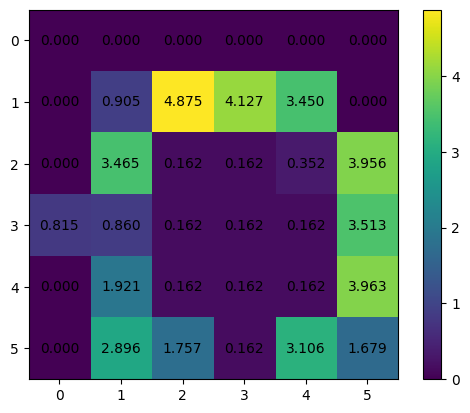

In [ ]:
kernel_size = (5,5)
test_idx = 0
layer_name = 'RGB_Conv2d'
if layer_name == 'Gray_Conv2d':
    split_img = split(gray_transform(test_images[test_idx]).unsqueeze(0), kernel_size, stride=kernel_size)
else:
    split_img = split(test_images[test_idx].unsqueeze(0), kernel_size, stride=kernel_size)
split_img = split_img[0].permute(1,2,3,4,0).detach().numpy()
print(split_img.shape)
plot_map(split_img, cmap='gray', vmax=1, vmin=0)

RM_CIs = get_RM_CIs(test_images[test_idx].unsqueeze(0))

RM_CI = RM_CIs[layer_name]['RM_CI']
RM_CI_idx = RM_CIs[layer_name]['RM_CI_idx']
print(RM_CI.shape)
print(RM_CI_idx.shape)
plot_map(RM_CI)

dist_arr = np.zeros((RM_CI.shape[:2]))
print(f"dist_arr: {dist_arr.shape}")
for i in range(RM_CI.shape[0]):
    for j in range(RM_CI.shape[1]):
        print(f"({i}, {j})")
        print(split_img[i][j][0][0])
        print(RM_CI[i][j][0][0])
        print()
        dist_arr[i][j] = cdist(split_img[i][j], RM_CI[i][j])

plt.imshow(dist_arr)
plt.colorbar()
for i in range(RM_CI.shape[0]):
    for j in range(RM_CI.shape[1]):
        text = plt.text(j, i, '{:.3f}'.format(dist_arr[i, j]), ha="center", va="center")
plt.show()


# i = dist_arr.argmin() // dist_arr.shape[1]
# j = dist_arr.argmin() % dist_arr.shape[1]
# print(f"dist_arr_idx: {i, j}")
# plt.imshow(RM_CI[i][j], cmap='gray', vmax=1, vmin=0)

# print(f"RM_CI_idx: {RM_CI_idx.shape}")
# train_img_idx = int(RM_CI_idx[i][j] // np.multiply(*dist_arr.shape))
# print(train_img_idx, (RM_CI_idx[i][j] % np.multiply(*dist_arr.shape))//RM_CI.shape[1], (RM_CI_idx[i][j] % np.multiply(*dist_arr.shape))%RM_CI.shape[1] )

# idx_image = train_images[train_img_idx]
# plt.imshow(idx_image.permute(1,2,0))
# plt.show()
# idx_image = split(idx_image.unsqueeze(0), kernel_size, stride=kernel_size)[0]
# idx_image = idx_image.permute(1,2,3,4,0)
# plot_map(idx_image, vmax = 1, vmin=0, cmap='gray')

# print(num_to_label[train_labels[train_img_idx].item()])

In [ ]:
from collections import defaultdict
voting = defaultdict(int)

In [ ]:
RM_CIs = get_RM_CIs(test_images[test_idx].unsqueeze(0))

## Inference Gray_conv2d

In [ ]:
split_img = split(gray_transform(test_images[test_idx]).unsqueeze(0))
split_img = split_img[0].permute(1,2,3,4,0).detach().numpy()

RM_CI = RM_CIs['Gray_Conv2d']['RM_CI']
RM_CI_idx = RM_CIs['Gray_Conv2d']['RM_CI_idx']

dist_arr = np.zeros((RM_CI.shape[:2]))
for i in range(RM_CI.shape[0]):
    for j in range(RM_CI.shape[1]):
        dist_arr[i][j] = cdist(split_img[i][j], RM_CI[i][j])

dist_i, dist_j = dist_arr.argmin() // dist_arr.shape[1], dist_arr.argmin() % dist_arr.shape[1]
train_img_idx = int(RM_CI_idx[i][j] // np.multiply(*dist_arr.shape))
voting[train_labels[train_img_idx].item()] += 1
print(num_to_label[train_labels[train_img_idx].item()])

rectangle_blue


C:\Users\user\AppData\Local\Temp\ipykernel_9016\3983888431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


## Inference Conv1

In [ ]:
kernel_size = (15,5)
split_img = split(test_images[test_idx].unsqueeze(0), kernel_size, stride=kernel_size)
split_img = split_img[0].permute(1,2,3,4,0).detach().numpy()

RM_CI = RM_CIs['Conv1']['RM_CI']
RM_CI_idx = RM_CIs['Conv1']['RM_CI_idx']

dist_arr = np.zeros((RM_CI.shape[:2]))
for i in range(RM_CI.shape[0]):
    for j in range(RM_CI.shape[1]):
        dist_arr[i][j] = cdist(split_img[i][j], RM_CI[i][j])

dist_row_idx = dist_arr.argmin() // dist_arr.shape[1]
dist_col_idx = dist_arr.argmin() % dist_arr.shape[1]
train_img_idx = int(RM_CI_idx[dist_row_idx][dist_col_idx] // np.multiply(*dist_arr.shape))
voting[train_labels[train_img_idx].item()] += 1
print(num_to_label[train_labels[train_img_idx].item()])

circle_red


C:\Users\user\AppData\Local\Temp\ipykernel_9016\3983888431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


## Inference Conv2

In [ ]:
kernel_size = (15,15)
split_img = split(test_images[test_idx].unsqueeze(0), kernel_size, stride=kernel_size)
split_img = split_img[0].permute(1,2,3,4,0).detach().numpy()

RM_CI = RM_CIs['Conv2']['RM_CI']
RM_CI_idx = RM_CIs['Conv2']['RM_CI_idx']

dist_arr = np.zeros((RM_CI.shape[:2]))
for i in range(RM_CI.shape[0]):
    for j in range(RM_CI.shape[1]):
        dist_arr[i][j] = cdist(split_img[i][j], RM_CI[i][j])

dist_row_idx = dist_arr.argmin() // dist_arr.shape[1]
dist_col_idx = dist_arr.argmin() % dist_arr.shape[1]
train_img_idx = int(RM_CI_idx[dist_row_idx][dist_col_idx] // np.multiply(*dist_arr.shape))
voting[train_labels[train_img_idx].item()] += 1
print(num_to_label[train_labels[train_img_idx].item()])

rectangle_blue


C:\Users\user\AppData\Local\Temp\ipykernel_9016\3983888431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


## Test inference accuracy

In [ ]:
image = test_images[test_idx]

voting = defaultdict(int)
kernel_sizes = [(5,5), (15,5), (15,15)]
layer_names = ['Gray_Conv2d', 'Conv1', 'Conv2']

RM_CIs = get_RM_CIs(image.unsqueeze(0))

for kernel_size, layer_name in zip(kernel_sizes, layer_names):
    if layer_name == 'Gray_Conv2d':
        split_img = split(gray_transform(image).unsqueeze(0), kernel_size, stride=kernel_size)
    else:
        split_img = split(image.unsqueeze(0), kernel_size, stride=kernel_size)
    split_img = split_img[0].permute(1,2,3,4,0).detach().numpy()

    RM_CI = RM_CIs[layer_name]['RM_CI']
    RM_CI_idx = RM_CIs[layer_name]['RM_CI_idx']

    dist_arr = np.zeros((RM_CI.shape[:2]))
    for i in range(RM_CI.shape[0]):
        for j in range(RM_CI.shape[1]):
            dist_arr[i][j] = cdist(split_img[i][j], RM_CI[i][j])

    dist_row_idx = dist_arr.argmin() // dist_arr.shape[1]
    dist_col_idx = dist_arr.argmin() % dist_arr.shape[1]
    train_img_idx = int(RM_CI_idx[dist_row_idx][dist_col_idx] // np.multiply(*dist_arr.shape))
    print(num_to_label[train_labels[train_img_idx].item()])
    voting[train_labels[train_img_idx].item()] += 1
pred = max(voting, key=voting.get)
print(num_to_label[pred])
print(voting)

circle_blue
circle_red
rectangle_blue
circle_blue
defaultdict(<class 'int'>, {2: 1, 0: 1, 5: 1})


C:\Users\user\AppData\Local\Temp\ipykernel_9016\3983888431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


C:\Users\user\AppData\Local\Temp\ipykernel_9016\3983888431.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input)


4 circle_blue circle_blue
7 circle_blue circle_blue
9 circle_blue circle_blue
10 circle_blue circle_blue
12 circle_blue circle_blue
16 circle_blue circle_blue
24 circle_blue circle_blue


30 circle_blue circle_blue
31 circle_blue circle_blue
38 circle_blue circle_blue
44 circle_blue circle_blue
46 circle_blue circle_blue
48 circle_blue circle_blue
49 circle_blue circle_blue
51 circle_blue circle_blue
52 circle_blue circle_blue
54 circle_blue circle_blue
55 circle_blue circle_blue
56 circle_blue circle_blue
58 circle_blue circle_blue
61 circle_blue circle_blue
63 circle_blue circle_blue
67 circle_blue circle_blue
68 circle_blue circle_blue
70 circle_blue circle_blue
80 circle_blue circle_blue
81 circle_blue circle_blue
83 circle_blue circle_blue
85 circle_blue circle_blue
86 circle_blue circle_blue
88 circle_blue circle_blue
93 circle_blue circle_blue
95 circle_blue circle_blue
96 circle_blue circle_blue
99 circle_blue circle_blue
101 circle_green circle_green
117 circle_green circle_green
118 circle_green circle_green
122 circle_green circle_green
124 circle_green circle_green
125 circle_green circle_green
126 circle_green circle_green
132 circle_green circle_green
135 

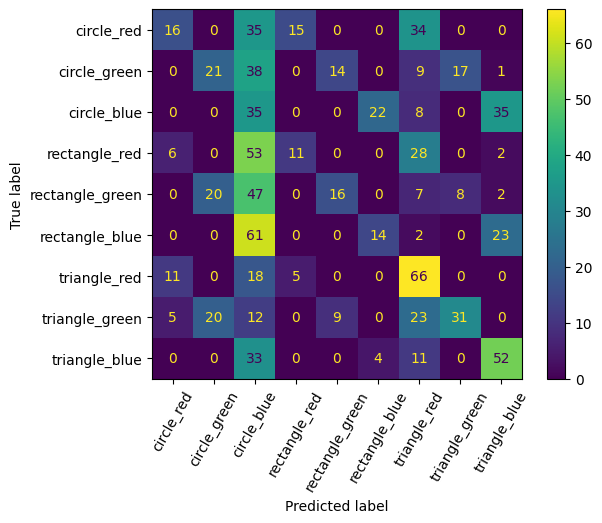

627
0.6966666666666667


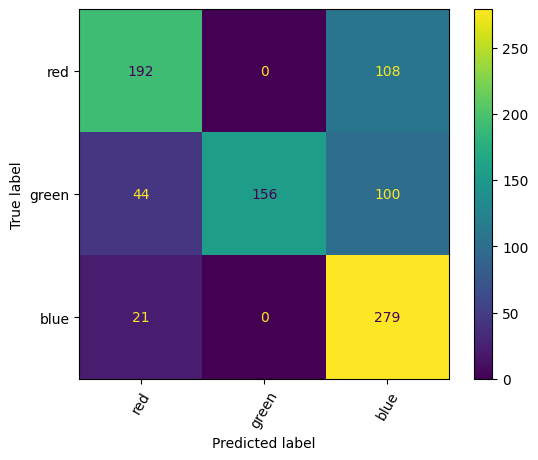

369
0.41


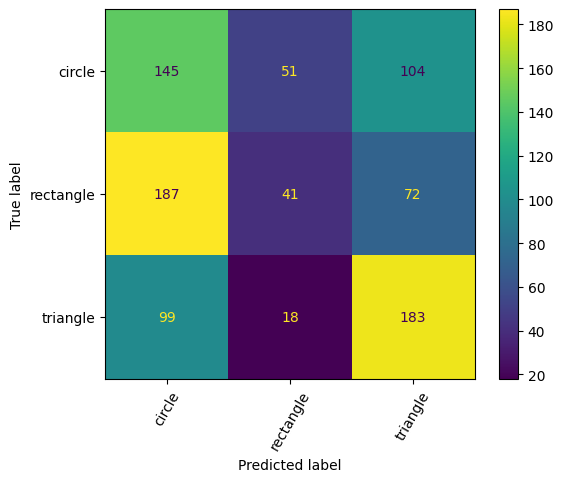

In [ ]:
from collections import defaultdict

correct = 0
correct_color = 0
correct_shape = 0
truth_labels = []
truth_color_labels = []
truth_shape_labels = []
predict_labels = []
predict_color_labels = []
predict_shape_labels = []

correct_idxs = []
for image_idx, (image, label) in enumerate(zip(test_images, test_labels)):
    voting = defaultdict(int)
    # kernel_sizes = [(5,5), (15,5), (15,15)]
    # layer_names = ['Gray_Conv2d', 'Conv1', 'Conv2']

    kernel_sizes = [(15,15)]
    layer_names = ['Conv2']

    RM_CIs = get_RM_CIs(image.unsqueeze(0))

    for kernel_size, layer_name in zip(kernel_sizes, layer_names):
        if layer_name == 'Gray_Conv2d':
            split_img = split(gray_transform(image).unsqueeze(0), kernel_size, stride=kernel_size)
        else:
            split_img = split(image.unsqueeze(0), kernel_size, stride=kernel_size)
        split_img = split_img[0].permute(1,2,3,4,0).detach().numpy()

        RM_CI = RM_CIs[layer_name]['RM_CI']
        RM_CI_idx = RM_CIs[layer_name]['RM_CI_idx']

        dist_arr = np.zeros((RM_CI.shape[:2]))
        for i in range(RM_CI.shape[0]):
            for j in range(RM_CI.shape[1]):
                dist_arr[i][j] = cdist(split_img[i][j], RM_CI[i][j])

        dist_row_idx = dist_arr.argmin() // dist_arr.shape[1]
        dist_col_idx = dist_arr.argmin() % dist_arr.shape[1]
        train_img_idx = int(RM_CI_idx[dist_row_idx][dist_col_idx] // np.multiply(*dist_arr.shape))
        voting[train_labels[train_img_idx].item()] += 1

    if max(list(voting.values())) == 1:
        pred = train_labels[train_img_idx].item()
    else:
        pred = max(voting, key=voting.get)

    predict_labels.append(num_to_label[pred])
    predict_shape_labels.append(pred // 3)
    predict_color_labels.append(pred % 3)
    truth_labels.append(num_to_label[label.item()])
    truth_shape_labels.append(label.item() // 3)
    truth_color_labels.append(label.item() % 3)

    if pred == label.item():
        correct += 1
        correct_idxs.append(image_idx)
        print(image_idx, num_to_label[label.item()], num_to_label[pred])
    if pred // 3 == label.item() // 3:
        correct_shape += 1
    if pred%3 == label.item()%3:
        correct_color += 1

print(correct)
print(correct / test_images.shape[0])

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(truth_labels, predict_labels, labels=label_names,  xticks_rotation = 60)
plt.show()

print(correct_color)
print(correct_color / test_images.shape[0])
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(truth_color_labels, predict_color_labels, labels=[0,1,2], display_labels=['red', 'green', 'blue'], xticks_rotation = 60)
plt.show()

print(correct_shape)
print(correct_shape / test_images.shape[0])
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(truth_shape_labels, predict_shape_labels, labels=[0,1,2], display_labels=['circle', 'rectangle', 'triangle'],  xticks_rotation = 60)
plt.show()

In [ ]:
print(correct_idxs)

[4, 7, 9, 10, 12, 16, 24, 30, 31, 38, 44, 46, 48, 49, 51, 52, 54, 55, 56, 58, 61, 63, 67, 68, 70, 80, 81, 83, 85, 86, 88, 93, 95, 96, 99, 101, 117, 118, 122, 124, 125, 126, 132, 135, 138, 150, 153, 157, 159, 160, 162, 172, 173, 185, 190, 197, 203, 208, 213, 219, 222, 230, 232, 238, 249, 257, 259, 260, 262, 270, 272, 289, 300, 302, 305, 306, 307, 314, 326, 341, 344, 351, 353, 361, 379, 382, 400, 406, 411, 413, 425, 426, 427, 434, 436, 451, 453, 462, 465, 475, 482, 485, 506, 526, 529, 531, 541, 544, 546, 551, 553, 559, 565, 607, 609, 610, 612, 613, 614, 615, 616, 617, 618, 620, 622, 623, 625, 626, 630, 632, 633, 634, 635, 637, 639, 641, 642, 643, 647, 649, 650, 652, 654, 655, 658, 660, 661, 662, 663, 672, 674, 678, 679, 684, 685, 686, 687, 690, 691, 692, 693, 695, 696, 697, 699, 701, 707, 711, 714, 716, 718, 720, 725, 730, 732, 733, 734, 739, 741, 743, 750, 752, 754, 755, 760, 768, 769, 775, 776, 778, 783, 784, 788, 793, 796, 797, 800, 801, 806, 809, 812, 813, 814, 815, 816, 817, 819, 82

In [ ]:
print(np.round(FMs['RGB_conv2d'][:, : , 0, 0, :], 3))

[[[0.177 0.192 0.935]
  [0.533 0.763 0.715]
  [0.431 0.44  0.486]
  [0.22  0.432 0.99 ]
  [0.488 0.637 0.196]
  [0.503 0.516 0.821]
  [0.964 0.417 0.359]
  [0.101 0.638 0.69 ]
  [0.836 0.349 0.55 ]
  [0.908 0.56  0.903]
  [0.319 0.04  0.291]
  [0.012 0.256 0.152]
  [0.695 0.563 0.608]
  [0.005 0.445 0.141]
  [0.542 0.69  0.742]]

 [[0.727 0.935 0.276]
  [0.273 0.513 0.96 ]
  [0.932 0.228 0.488]
  [0.234 0.37  0.109]
  [0.453 0.196 0.665]
  [0.088 0.675 0.568]
  [0.517 0.932 0.658]
  [0.616 0.747 0.147]
  [0.658 0.326 0.499]
  [0.443 0.3   0.966]
  [0.    0.77  0.275]
  [0.531 0.125 0.206]
  [0.355 0.698 0.357]
  [0.965 1.    0.954]
  [0.292 0.68  0.215]]

 [[0.101 0.792 0.99 ]
  [0.431 0.777 0.026]
  [0.872 0.091 0.249]
  [0.1   0.683 0.278]
  [0.476 0.485 0.558]
  [0.642 0.548 0.909]
  [0.863 0.765 0.951]
  [0.066 0.772 0.401]
  [0.346 0.911 0.209]
  [0.953 0.235 0.192]
  [0.756 0.03  0.404]
  [0.56  0.762 0.037]
  [0.554 0.946 0.926]
  [0.75  0.023 0.838]
  [0.162 0.857 0.765]]

 [[0

In [ ]:
print(np.round(CIs['RGB_Conv2d']['CI'][:, : , 0, 0, :], 3))

tensor([[[0.0660, 0.0660, 1.0000]],

        [[0.6330, 1.0000, 0.6330]],

        [[0.3670, 0.3670, 1.0000]],

        [[0.3670, 0.3670, 1.0000]],

        [[0.3670, 1.0000, 0.3670]],

        [[1.0000, 1.0000, 1.0000]],

        [[1.0000, 0.3670, 0.3670]],

        [[0.3670, 0.3670, 1.0000]],

        [[1.0000, 0.3670, 0.3670]],

        [[1.0000, 1.0000, 1.0000]],

        [[1.0000, 0.0660, 0.0660]],

        [[0.0660, 1.0000, 0.0660]],

        [[1.0000, 1.0000, 1.0000]],

        [[0.0660, 1.0000, 0.0660]],

        [[0.4010, 0.4010, 1.0000]],

        [[0.3670, 1.0000, 0.3670]],

        [[0.3670, 0.3670, 1.0000]],

        [[1.0000, 0.3670, 0.3670]],

        [[0.0660, 1.0000, 0.0660]],

        [[0.3670, 0.3670, 1.0000]],

        [[0.3670, 1.0000, 0.3670]],

        [[1.0000, 1.0000, 1.0000]],

        [[0.3670, 1.0000, 0.3670]],

        [[1.0000, 0.3670, 0.3670]],

        [[0.3670, 0.3670, 1.0000]],

        [[0.0660, 1.0000, 0.0660]],

        [[1.0000, 0.0660, 0.0660]],

 